In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,bid,ask,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.763714,0.764857,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.667400,196.962600,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.527500,196.822500,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.522500,196.817500,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.092800,196.387200,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

# look_backs = [30, 45, 60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.05, 0.35),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.05, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.05, 0.35),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    1e-5, 1e-3,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-5, 1e-2,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.1, 10),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors (disk-backed memmaps)...')
    X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models_core.build_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models_core.chronological_split(
        X, y_sig, y_ret,
        raw_close, raw_bid, raw_ask,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
        # train split:   
        X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,           y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,            y_sig_te,     y_ret_te,   end_times_te,
        raw_close_te, raw_bid_te, raw_ask_te,
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = dual_lstm.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = dual_lstm.lstm_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_bid, raw_ask
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del raw_close_te, raw_bid_te, raw_ask_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


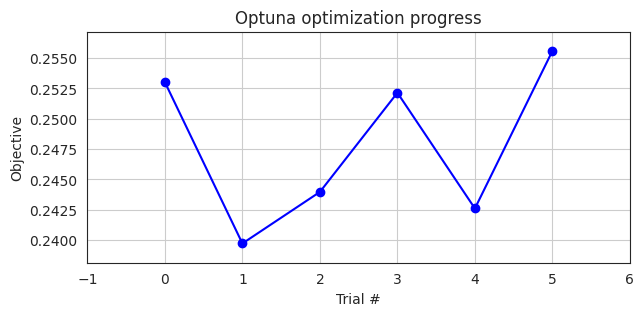

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-21 18:49:51,967] A new study created in RDB with name: no-name-58a09912-7cca-47dd-b718-7e9c6cdc4651



▶ Trial 0 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.3183154112889319, 'DROPOUT_LONG': 0.23151819664607176, 'ATT_DROPOUT': 0.2241235586982981, 'INITIAL_LR': 1.7055426245214335e-05, 'ETA_MIN': 5.9668238347400925e-06, 'WEIGHT_DECAY': 2.0337506479638552e-05, 'CLIPNORM': 0.5110608011932125}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


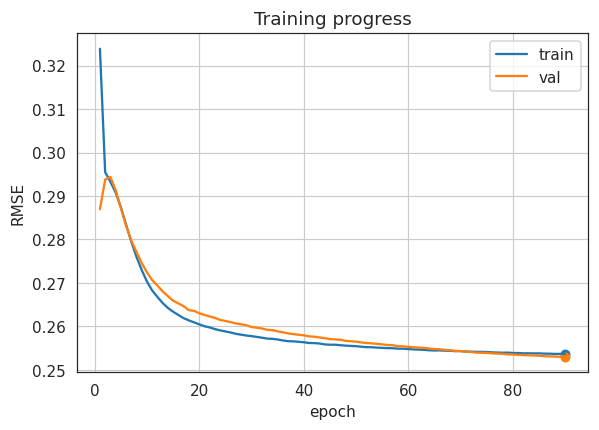

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3239 MAE=0.2835 R2=-0.2294 | "B": Acc=0.7088 Prec=0.2717 Rec=0.0191 F1=0.0358 AUROC=0.4891
VALID→ "R": RMSE=0.2870 MAE=0.2273 R2=0.0142 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4802
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.28697_chp.pth


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2955 MAE=0.2389 R2=-0.0234 | "B": Acc=0.7018 Prec=0.2677 Rec=0.0327 F1=0.0583 AUROC=0.4878
VALID→ "R": RMSE=0.2938 MAE=0.2116 R2=-0.0330 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4305


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2933 MAE=0.2275 R2=-0.0081 | "B": Acc=0.6915 Prec=0.2667 Rec=0.0535 F1=0.0891 AUROC=0.4875
VALID→ "R": RMSE=0.2944 MAE=0.2083 R2=-0.0374 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4081


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2908 MAE=0.2234 R2=0.0086 | "B": Acc=0.6776 Prec=0.2656 Rec=0.0808 F1=0.1239 AUROC=0.4869
VALID→ "R": RMSE=0.2914 MAE=0.2053 R2=-0.0164 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3950


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2874 MAE=0.2207 R2=0.0317 | "B": Acc=0.6634 Prec=0.2644 Rec=0.1083 F1=0.1537 AUROC=0.4855
VALID→ "R": RMSE=0.2873 MAE=0.2021 R2=0.0119 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3920


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2834 MAE=0.2180 R2=0.0585 | "B": Acc=0.6492 Prec=0.2603 Rec=0.1322 F1=0.1754 AUROC=0.4820
VALID→ "R": RMSE=0.2832 MAE=0.1991 R2=0.0401 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3951
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.28317_chp.pth


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2795 MAE=0.2154 R2=0.0844 | "B": Acc=0.6378 Prec=0.2586 Rec=0.1520 F1=0.1915 AUROC=0.4800
VALID→ "R": RMSE=0.2798 MAE=0.1964 R2=0.0632 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3989
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.27975_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2760 MAE=0.2129 R2=0.1073 | "B": Acc=0.6287 Prec=0.2572 Rec=0.1676 F1=0.2029 AUROC=0.4783
VALID→ "R": RMSE=0.2771 MAE=0.1942 R2=0.0808 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3967
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.27711_chp.pth


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2730 MAE=0.2106 R2=0.1267 | "B": Acc=0.6216 Prec=0.2547 Rec=0.1772 F1=0.2090 AUROC=0.4757
VALID→ "R": RMSE=0.2746 MAE=0.1924 R2=0.0975 | "B": Acc=0.7049 Prec=0.1818 Rec=0.0000 F1=0.0000 AUROC=0.3885
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.27457_chp.pth


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2703 MAE=0.2087 R2=0.1435 | "B": Acc=0.6161 Prec=0.2547 Rec=0.1874 F1=0.2159 AUROC=0.4741
VALID→ "R": RMSE=0.2724 MAE=0.1911 R2=0.1116 | "B": Acc=0.7048 Prec=0.2424 Rec=0.0002 F1=0.0003 AUROC=0.3742
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.27242_chp.pth


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2683 MAE=0.2076 R2=0.1565 | "B": Acc=0.6116 Prec=0.2523 Rec=0.1917 F1=0.2179 AUROC=0.4721
VALID→ "R": RMSE=0.2707 MAE=0.1901 R2=0.1231 | "B": Acc=0.7046 Prec=0.2793 Rec=0.0005 F1=0.0011 AUROC=0.3590
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.27065_chp.pth


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2668 MAE=0.2064 R2=0.1657 | "B": Acc=0.6058 Prec=0.2520 Rec=0.2018 F1=0.2241 AUROC=0.4710
VALID→ "R": RMSE=0.2694 MAE=0.1894 R2=0.1311 | "B": Acc=0.7036 Prec=0.1784 Rec=0.0012 F1=0.0024 AUROC=0.3450
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26941_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2654 MAE=0.2048 R2=0.1745 | "B": Acc=0.5981 Prec=0.2490 Rec=0.2106 F1=0.2282 AUROC=0.4676
VALID→ "R": RMSE=0.2681 MAE=0.1887 R2=0.1398 | "B": Acc=0.6988 Prec=0.1348 Rec=0.0038 F1=0.0075 AUROC=0.3325
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26806_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2643 MAE=0.2039 R2=0.1815 | "B": Acc=0.5910 Prec=0.2504 Rec=0.2256 F1=0.2374 AUROC=0.4669
VALID→ "R": RMSE=0.2670 MAE=0.1881 R2=0.1468 | "B": Acc=0.6836 Prec=0.1227 Rec=0.0117 F1=0.0214 AUROC=0.3248
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26697_chp.pth


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2634 MAE=0.2030 R2=0.1869 | "B": Acc=0.5812 Prec=0.2492 Rec=0.2406 F1=0.2448 AUROC=0.4645
VALID→ "R": RMSE=0.2659 MAE=0.1876 R2=0.1535 | "B": Acc=0.6526 Prec=0.1217 Rec=0.0285 F1=0.0462 AUROC=0.3202
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26593_chp.pth


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2626 MAE=0.2023 R2=0.1915 | "B": Acc=0.5718 Prec=0.2493 Rec=0.2575 F1=0.2534 AUROC=0.4635
VALID→ "R": RMSE=0.2653 MAE=0.1871 R2=0.1574 | "B": Acc=0.6139 Prec=0.1243 Rec=0.0510 F1=0.0723 AUROC=0.3189
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26530_chp.pth


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2619 MAE=0.2016 R2=0.1959 | "B": Acc=0.5641 Prec=0.2500 Rec=0.2725 F1=0.2608 AUROC=0.4622
VALID→ "R": RMSE=0.2647 MAE=0.1868 R2=0.1614 | "B": Acc=0.5654 Prec=0.1286 Rec=0.0819 F1=0.1001 AUROC=0.3180
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26468_chp.pth


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2614 MAE=0.2010 R2=0.1992 | "B": Acc=0.5548 Prec=0.2502 Rec=0.2896 F1=0.2685 AUROC=0.4611
VALID→ "R": RMSE=0.2638 MAE=0.1864 R2=0.1673 | "B": Acc=0.5304 Prec=0.1348 Rec=0.1091 F1=0.1206 AUROC=0.3176
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26375_chp.pth


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2609 MAE=0.2006 R2=0.2020 | "B": Acc=0.5488 Prec=0.2497 Rec=0.2988 F1=0.2720 AUROC=0.4599
VALID→ "R": RMSE=0.2636 MAE=0.1861 R2=0.1683 | "B": Acc=0.5040 Prec=0.1412 Rec=0.1339 F1=0.1375 AUROC=0.3170
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26358_chp.pth


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2605 MAE=0.2000 R2=0.2048 | "B": Acc=0.5429 Prec=0.2510 Rec=0.3125 F1=0.2784 AUROC=0.4601
VALID→ "R": RMSE=0.2630 MAE=0.1858 R2=0.1718 | "B": Acc=0.4740 Prec=0.1484 Rec=0.1651 F1=0.1563 AUROC=0.3166
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26303_chp.pth


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2600 MAE=0.1996 R2=0.2074 | "B": Acc=0.5353 Prec=0.2507 Rec=0.3254 F1=0.2832 AUROC=0.4588
VALID→ "R": RMSE=0.2626 MAE=0.1855 R2=0.1742 | "B": Acc=0.4512 Prec=0.1549 Rec=0.1929 F1=0.1718 AUROC=0.3163
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26264_chp.pth


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2598 MAE=0.1994 R2=0.2091 | "B": Acc=0.5297 Prec=0.2503 Rec=0.3343 F1=0.2863 AUROC=0.4572
VALID→ "R": RMSE=0.2623 MAE=0.1853 R2=0.1764 | "B": Acc=0.4372 Prec=0.1609 Rec=0.2151 F1=0.1841 AUROC=0.3167
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26230_chp.pth


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2594 MAE=0.1990 R2=0.2114 | "B": Acc=0.5247 Prec=0.2503 Rec=0.3432 F1=0.2895 AUROC=0.4564
VALID→ "R": RMSE=0.2620 MAE=0.1851 R2=0.1785 | "B": Acc=0.4292 Prec=0.1630 Rec=0.2259 F1=0.1893 AUROC=0.3159
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26197_chp.pth


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2591 MAE=0.1988 R2=0.2133 | "B": Acc=0.5226 Prec=0.2515 Rec=0.3503 F1=0.2928 AUROC=0.4571
VALID→ "R": RMSE=0.2615 MAE=0.1849 R2=0.1814 | "B": Acc=0.4228 Prec=0.1633 Rec=0.2319 F1=0.1917 AUROC=0.3144
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26150_chp.pth


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2589 MAE=0.1985 R2=0.2147 | "B": Acc=0.5192 Prec=0.2510 Rec=0.3551 F1=0.2941 AUROC=0.4550
VALID→ "R": RMSE=0.2613 MAE=0.1847 R2=0.1829 | "B": Acc=0.4124 Prec=0.1666 Rec=0.2477 F1=0.1992 AUROC=0.3131
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26126_chp.pth


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2586 MAE=0.1983 R2=0.2162 | "B": Acc=0.5177 Prec=0.2502 Rec=0.3554 F1=0.2937 AUROC=0.4542
VALID→ "R": RMSE=0.2610 MAE=0.1846 R2=0.1845 | "B": Acc=0.4159 Prec=0.1642 Rec=0.2393 F1=0.1947 AUROC=0.3126
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26100_chp.pth


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2583 MAE=0.1980 R2=0.2180 | "B": Acc=0.5170 Prec=0.2508 Rec=0.3584 F1=0.2951 AUROC=0.4545
VALID→ "R": RMSE=0.2607 MAE=0.1845 R2=0.1865 | "B": Acc=0.4181 Prec=0.1619 Rec=0.2328 F1=0.1910 AUROC=0.3118
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26069_chp.pth


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2581 MAE=0.1978 R2=0.2192 | "B": Acc=0.5158 Prec=0.2507 Rec=0.3601 F1=0.2956 AUROC=0.4537
VALID→ "R": RMSE=0.2605 MAE=0.1843 R2=0.1877 | "B": Acc=0.4184 Prec=0.1606 Rec=0.2296 F1=0.1890 AUROC=0.3108
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26049_chp.pth


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2579 MAE=0.1976 R2=0.2204 | "B": Acc=0.5133 Prec=0.2487 Rec=0.3589 F1=0.2938 AUROC=0.4516
VALID→ "R": RMSE=0.2603 MAE=0.1842 R2=0.1890 | "B": Acc=0.4124 Prec=0.1619 Rec=0.2372 F1=0.1924 AUROC=0.3094
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26028_chp.pth


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2578 MAE=0.1975 R2=0.2212 | "B": Acc=0.5125 Prec=0.2493 Rec=0.3619 F1=0.2952 AUROC=0.4513
VALID→ "R": RMSE=0.2599 MAE=0.1841 R2=0.1916 | "B": Acc=0.4137 Prec=0.1597 Rec=0.2315 F1=0.1890 AUROC=0.3080
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25986_chp.pth


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2576 MAE=0.1974 R2=0.2223 | "B": Acc=0.5114 Prec=0.2483 Rec=0.3609 F1=0.2942 AUROC=0.4502
VALID→ "R": RMSE=0.2597 MAE=0.1840 R2=0.1927 | "B": Acc=0.4133 Prec=0.1584 Rec=0.2292 F1=0.1874 AUROC=0.3061
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25970_chp.pth


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2574 MAE=0.1973 R2=0.2234 | "B": Acc=0.5117 Prec=0.2481 Rec=0.3600 F1=0.2938 AUROC=0.4497
VALID→ "R": RMSE=0.2595 MAE=0.1840 R2=0.1937 | "B": Acc=0.4147 Prec=0.1567 Rec=0.2244 F1=0.1846 AUROC=0.3050
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25954_chp.pth


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2572 MAE=0.1969 R2=0.2246 | "B": Acc=0.5121 Prec=0.2479 Rec=0.3587 F1=0.2932 AUROC=0.4492
VALID→ "R": RMSE=0.2592 MAE=0.1839 R2=0.1956 | "B": Acc=0.4191 Prec=0.1544 Rec=0.2163 F1=0.1802 AUROC=0.3047
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25923_chp.pth


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2571 MAE=0.1970 R2=0.2250 | "B": Acc=0.5125 Prec=0.2468 Rec=0.3547 F1=0.2910 AUROC=0.4484
VALID→ "R": RMSE=0.2591 MAE=0.1838 R2=0.1961 | "B": Acc=0.4220 Prec=0.1524 Rec=0.2101 F1=0.1766 AUROC=0.3037
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25914_chp.pth


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2570 MAE=0.1969 R2=0.2259 | "B": Acc=0.5125 Prec=0.2463 Rec=0.3535 F1=0.2903 AUROC=0.4466
VALID→ "R": RMSE=0.2589 MAE=0.1838 R2=0.1978 | "B": Acc=0.4222 Prec=0.1511 Rec=0.2074 F1=0.1748 AUROC=0.3025
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25887_chp.pth


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2568 MAE=0.1966 R2=0.2273 | "B": Acc=0.5131 Prec=0.2462 Rec=0.3519 F1=0.2897 AUROC=0.4464
VALID→ "R": RMSE=0.2587 MAE=0.1837 R2=0.1991 | "B": Acc=0.4256 Prec=0.1491 Rec=0.2010 F1=0.1712 AUROC=0.3023
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25865_chp.pth


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2566 MAE=0.1965 R2=0.2283 | "B": Acc=0.5126 Prec=0.2454 Rec=0.3507 F1=0.2888 AUROC=0.4460
VALID→ "R": RMSE=0.2584 MAE=0.1837 R2=0.2007 | "B": Acc=0.4255 Prec=0.1487 Rec=0.2005 F1=0.1708 AUROC=0.3014
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25840_chp.pth


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2566 MAE=0.1965 R2=0.2285 | "B": Acc=0.5141 Prec=0.2457 Rec=0.3489 F1=0.2883 AUROC=0.4463
VALID→ "R": RMSE=0.2582 MAE=0.1836 R2=0.2018 | "B": Acc=0.4317 Prec=0.1466 Rec=0.1921 F1=0.1663 AUROC=0.3017
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25823_chp.pth


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2565 MAE=0.1963 R2=0.2291 | "B": Acc=0.5148 Prec=0.2456 Rec=0.3473 F1=0.2877 AUROC=0.4459
VALID→ "R": RMSE=0.2581 MAE=0.1836 R2=0.2027 | "B": Acc=0.4346 Prec=0.1461 Rec=0.1890 F1=0.1648 AUROC=0.3023
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25808_chp.pth


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2564 MAE=0.1962 R2=0.2297 | "B": Acc=0.5147 Prec=0.2452 Rec=0.3464 F1=0.2871 AUROC=0.4457
VALID→ "R": RMSE=0.2580 MAE=0.1836 R2=0.2034 | "B": Acc=0.4357 Prec=0.1462 Rec=0.1886 F1=0.1647 AUROC=0.3033
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25796_chp.pth


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2562 MAE=0.1961 R2=0.2308 | "B": Acc=0.5150 Prec=0.2451 Rec=0.3457 F1=0.2869 AUROC=0.4453
VALID→ "R": RMSE=0.2577 MAE=0.1836 R2=0.2050 | "B": Acc=0.4407 Prec=0.1447 Rec=0.1822 F1=0.1613 AUROC=0.3033
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25771_chp.pth


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2562 MAE=0.1961 R2=0.2309 | "B": Acc=0.5152 Prec=0.2444 Rec=0.3435 F1=0.2856 AUROC=0.4443
VALID→ "R": RMSE=0.2576 MAE=0.1835 R2=0.2054 | "B": Acc=0.4381 Prec=0.1461 Rec=0.1866 F1=0.1639 AUROC=0.3036
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25764_chp.pth


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2561 MAE=0.1959 R2=0.2315 | "B": Acc=0.5148 Prec=0.2447 Rec=0.3450 F1=0.2863 AUROC=0.4445
VALID→ "R": RMSE=0.2575 MAE=0.1835 R2=0.2064 | "B": Acc=0.4425 Prec=0.1454 Rec=0.1822 F1=0.1617 AUROC=0.3044
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25747_chp.pth


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2559 MAE=0.1958 R2=0.2327 | "B": Acc=0.5159 Prec=0.2447 Rec=0.3430 F1=0.2856 AUROC=0.4446
VALID→ "R": RMSE=0.2573 MAE=0.1835 R2=0.2075 | "B": Acc=0.4476 Prec=0.1452 Rec=0.1784 F1=0.1601 AUROC=0.3053
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25731_chp.pth


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2558 MAE=0.1957 R2=0.2331 | "B": Acc=0.5150 Prec=0.2438 Rec=0.3420 F1=0.2846 AUROC=0.4432
VALID→ "R": RMSE=0.2571 MAE=0.1835 R2=0.2088 | "B": Acc=0.4442 Prec=0.1474 Rec=0.1846 F1=0.1639 AUROC=0.3062
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25709_chp.pth


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2558 MAE=0.1957 R2=0.2331 | "B": Acc=0.5140 Prec=0.2443 Rec=0.3451 F1=0.2861 AUROC=0.4432
VALID→ "R": RMSE=0.2570 MAE=0.1834 R2=0.2093 | "B": Acc=0.4411 Prec=0.1500 Rec=0.1916 F1=0.1683 AUROC=0.3078
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25701_chp.pth


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2557 MAE=0.1956 R2=0.2338 | "B": Acc=0.5148 Prec=0.2447 Rec=0.3450 F1=0.2863 AUROC=0.4442
VALID→ "R": RMSE=0.2569 MAE=0.1834 R2=0.2097 | "B": Acc=0.4467 Prec=0.1498 Rec=0.1871 F1=0.1664 AUROC=0.3091
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25694_chp.pth


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2556 MAE=0.1954 R2=0.2344 | "B": Acc=0.5150 Prec=0.2445 Rec=0.3439 F1=0.2858 AUROC=0.4441
VALID→ "R": RMSE=0.2567 MAE=0.1834 R2=0.2113 | "B": Acc=0.4515 Prec=0.1496 Rec=0.1832 F1=0.1647 AUROC=0.3098
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25668_chp.pth


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2555 MAE=0.1954 R2=0.2348 | "B": Acc=0.5165 Prec=0.2448 Rec=0.3423 F1=0.2854 AUROC=0.4441
VALID→ "R": RMSE=0.2566 MAE=0.1834 R2=0.2118 | "B": Acc=0.4557 Prec=0.1508 Rec=0.1824 F1=0.1651 AUROC=0.3116
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25659_chp.pth


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2555 MAE=0.1953 R2=0.2352 | "B": Acc=0.5150 Prec=0.2442 Rec=0.3433 F1=0.2854 AUROC=0.4435
VALID→ "R": RMSE=0.2565 MAE=0.1834 R2=0.2124 | "B": Acc=0.4558 Prec=0.1534 Rec=0.1868 F1=0.1685 AUROC=0.3141
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25650_chp.pth


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2553 MAE=0.1952 R2=0.2358 | "B": Acc=0.5143 Prec=0.2441 Rec=0.3442 F1=0.2857 AUROC=0.4439
VALID→ "R": RMSE=0.2563 MAE=0.1834 R2=0.2135 | "B": Acc=0.4538 Prec=0.1562 Rec=0.1932 F1=0.1727 AUROC=0.3161
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25632_chp.pth


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2552 MAE=0.1951 R2=0.2365 | "B": Acc=0.5138 Prec=0.2446 Rec=0.3463 F1=0.2867 AUROC=0.4436
VALID→ "R": RMSE=0.2562 MAE=0.1834 R2=0.2144 | "B": Acc=0.4608 Prec=0.1568 Rec=0.1890 F1=0.1714 AUROC=0.3177
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25618_chp.pth


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2552 MAE=0.1951 R2=0.2366 | "B": Acc=0.5138 Prec=0.2447 Rec=0.3466 F1=0.2869 AUROC=0.4439
VALID→ "R": RMSE=0.2561 MAE=0.1834 R2=0.2149 | "B": Acc=0.4630 Prec=0.1593 Rec=0.1917 F1=0.1740 AUROC=0.3200
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25610_chp.pth


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2551 MAE=0.1950 R2=0.2371 | "B": Acc=0.5127 Prec=0.2441 Rec=0.3467 F1=0.2865 AUROC=0.4428
VALID→ "R": RMSE=0.2560 MAE=0.1834 R2=0.2155 | "B": Acc=0.4630 Prec=0.1621 Rec=0.1966 F1=0.1777 AUROC=0.3217
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25600_chp.pth


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2551 MAE=0.1949 R2=0.2375 | "B": Acc=0.5132 Prec=0.2447 Rec=0.3477 F1=0.2873 AUROC=0.4439
VALID→ "R": RMSE=0.2559 MAE=0.1834 R2=0.2163 | "B": Acc=0.4693 Prec=0.1635 Rec=0.1940 F1=0.1775 AUROC=0.3237
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25587_chp.pth


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2550 MAE=0.1949 R2=0.2378 | "B": Acc=0.5140 Prec=0.2453 Rec=0.3480 F1=0.2878 AUROC=0.4439
VALID→ "R": RMSE=0.2557 MAE=0.1834 R2=0.2171 | "B": Acc=0.4665 Prec=0.1658 Rec=0.2004 F1=0.1815 AUROC=0.3250
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25573_chp.pth


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2550 MAE=0.1948 R2=0.2380 | "B": Acc=0.5109 Prec=0.2452 Rec=0.3531 F1=0.2894 AUROC=0.4435
VALID→ "R": RMSE=0.2557 MAE=0.1834 R2=0.2174 | "B": Acc=0.4647 Prec=0.1691 Rec=0.2080 F1=0.1866 AUROC=0.3275
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25569_chp.pth


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2549 MAE=0.1947 R2=0.2386 | "B": Acc=0.5109 Prec=0.2458 Rec=0.3548 F1=0.2904 AUROC=0.4442
VALID→ "R": RMSE=0.2555 MAE=0.1834 R2=0.2187 | "B": Acc=0.4621 Prec=0.1732 Rec=0.2181 F1=0.1931 AUROC=0.3305
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25547_chp.pth


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2549 MAE=0.1948 R2=0.2386 | "B": Acc=0.5094 Prec=0.2452 Rec=0.3555 F1=0.2902 AUROC=0.4431
VALID→ "R": RMSE=0.2554 MAE=0.1834 R2=0.2191 | "B": Acc=0.4691 Prec=0.1752 Rec=0.2155 F1=0.1932 AUROC=0.3332
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25541_chp.pth


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2548 MAE=0.1947 R2=0.2392 | "B": Acc=0.5121 Prec=0.2465 Rec=0.3545 F1=0.2908 AUROC=0.4449
VALID→ "R": RMSE=0.2553 MAE=0.1834 R2=0.2197 | "B": Acc=0.4749 Prec=0.1773 Rec=0.2141 F1=0.1940 AUROC=0.3352
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25531_chp.pth


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ "R": RMSE=0.2547 MAE=0.1947 R2=0.2396 | "B": Acc=0.5096 Prec=0.2456 Rec=0.3561 F1=0.2907 AUROC=0.4434
VALID→ "R": RMSE=0.2552 MAE=0.1834 R2=0.2204 | "B": Acc=0.4699 Prec=0.1817 Rec=0.2272 F1=0.2019 AUROC=0.3382
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25519_chp.pth


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ "R": RMSE=0.2547 MAE=0.1946 R2=0.2399 | "B": Acc=0.5084 Prec=0.2460 Rec=0.3594 F1=0.2921 AUROC=0.4442
VALID→ "R": RMSE=0.2551 MAE=0.1834 R2=0.2209 | "B": Acc=0.4751 Prec=0.1831 Rec=0.2249 F1=0.2018 AUROC=0.3399
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25512_chp.pth


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ "R": RMSE=0.2546 MAE=0.1945 R2=0.2402 | "B": Acc=0.5089 Prec=0.2457 Rec=0.3577 F1=0.2913 AUROC=0.4434
VALID→ "R": RMSE=0.2551 MAE=0.1834 R2=0.2211 | "B": Acc=0.4771 Prec=0.1866 Rec=0.2298 F1=0.2059 AUROC=0.3430
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25508_chp.pth


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ "R": RMSE=0.2545 MAE=0.1944 R2=0.2407 | "B": Acc=0.5084 Prec=0.2456 Rec=0.3584 F1=0.2915 AUROC=0.4437
VALID→ "R": RMSE=0.2549 MAE=0.1834 R2=0.2221 | "B": Acc=0.4825 Prec=0.1895 Rec=0.2299 F1=0.2077 AUROC=0.3458
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25492_chp.pth


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ "R": RMSE=0.2545 MAE=0.1944 R2=0.2411 | "B": Acc=0.5079 Prec=0.2457 Rec=0.3596 F1=0.2920 AUROC=0.4437
VALID→ "R": RMSE=0.2548 MAE=0.1835 R2=0.2228 | "B": Acc=0.4779 Prec=0.1940 Rec=0.2438 F1=0.2161 AUROC=0.3494
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25480_chp.pth


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ "R": RMSE=0.2545 MAE=0.1944 R2=0.2409 | "B": Acc=0.5061 Prec=0.2471 Rec=0.3669 F1=0.2953 AUROC=0.4449
VALID→ "R": RMSE=0.2547 MAE=0.1834 R2=0.2232 | "B": Acc=0.4761 Prec=0.1980 Rec=0.2541 F1=0.2226 AUROC=0.3529
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25474_chp.pth


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ "R": RMSE=0.2544 MAE=0.1944 R2=0.2413 | "B": Acc=0.5050 Prec=0.2472 Rec=0.3689 F1=0.2960 AUROC=0.4443
VALID→ "R": RMSE=0.2546 MAE=0.1835 R2=0.2239 | "B": Acc=0.4765 Prec=0.2002 Rec=0.2583 F1=0.2256 AUROC=0.3549
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25462_chp.pth


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ "R": RMSE=0.2544 MAE=0.1943 R2=0.2415 | "B": Acc=0.5046 Prec=0.2477 Rec=0.3710 F1=0.2970 AUROC=0.4447
VALID→ "R": RMSE=0.2545 MAE=0.1835 R2=0.2246 | "B": Acc=0.4811 Prec=0.2036 Rec=0.2604 F1=0.2285 AUROC=0.3588
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25451_chp.pth


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ "R": RMSE=0.2543 MAE=0.1944 R2=0.2420 | "B": Acc=0.5046 Prec=0.2474 Rec=0.3702 F1=0.2966 AUROC=0.4449
VALID→ "R": RMSE=0.2544 MAE=0.1835 R2=0.2255 | "B": Acc=0.4882 Prec=0.2060 Rec=0.2572 F1=0.2288 AUROC=0.3611
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25436_chp.pth


Epoch 70:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ "R": RMSE=0.2543 MAE=0.1943 R2=0.2419 | "B": Acc=0.5047 Prec=0.2483 Rec=0.3728 F1=0.2981 AUROC=0.4456
VALID→ "R": RMSE=0.2543 MAE=0.1835 R2=0.2257 | "B": Acc=0.4861 Prec=0.2092 Rec=0.2667 F1=0.2345 AUROC=0.3641
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25433_chp.pth


Epoch 71:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ "R": RMSE=0.2542 MAE=0.1943 R2=0.2425 | "B": Acc=0.5040 Prec=0.2486 Rec=0.3750 F1=0.2990 AUROC=0.4459
VALID→ "R": RMSE=0.2542 MAE=0.1835 R2=0.2266 | "B": Acc=0.4861 Prec=0.2111 Rec=0.2708 F1=0.2372 AUROC=0.3659
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25419_chp.pth


Epoch 72:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ "R": RMSE=0.2542 MAE=0.1943 R2=0.2427 | "B": Acc=0.5028 Prec=0.2486 Rec=0.3768 F1=0.2995 AUROC=0.4455
VALID→ "R": RMSE=0.2541 MAE=0.1835 R2=0.2270 | "B": Acc=0.4879 Prec=0.2135 Rec=0.2741 F1=0.2401 AUROC=0.3679
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25411_chp.pth


Epoch 73:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ "R": RMSE=0.2542 MAE=0.1942 R2=0.2429 | "B": Acc=0.5032 Prec=0.2488 Rec=0.3768 F1=0.2997 AUROC=0.4461
VALID→ "R": RMSE=0.2540 MAE=0.1836 R2=0.2278 | "B": Acc=0.4840 Prec=0.2171 Rec=0.2872 F1=0.2473 AUROC=0.3713
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25398_chp.pth


Epoch 74:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ "R": RMSE=0.2541 MAE=0.1943 R2=0.2430 | "B": Acc=0.5011 Prec=0.2481 Rec=0.3782 F1=0.2996 AUROC=0.4453
VALID→ "R": RMSE=0.2539 MAE=0.1835 R2=0.2281 | "B": Acc=0.4941 Prec=0.2197 Rec=0.2800 F1=0.2462 AUROC=0.3743
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25394_chp.pth


Epoch 75:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ "R": RMSE=0.2541 MAE=0.1942 R2=0.2432 | "B": Acc=0.5024 Prec=0.2491 Rec=0.3792 F1=0.3007 AUROC=0.4462
VALID→ "R": RMSE=0.2539 MAE=0.1835 R2=0.2283 | "B": Acc=0.4927 Prec=0.2227 Rec=0.2887 F1=0.2514 AUROC=0.3777
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25390_chp.pth


Epoch 76:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ "R": RMSE=0.2540 MAE=0.1941 R2=0.2437 | "B": Acc=0.5025 Prec=0.2494 Rec=0.3800 F1=0.3012 AUROC=0.4468
VALID→ "R": RMSE=0.2538 MAE=0.1835 R2=0.2288 | "B": Acc=0.4985 Prec=0.2245 Rec=0.2851 F1=0.2512 AUROC=0.3794
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25381_chp.pth


Epoch 77:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ "R": RMSE=0.2540 MAE=0.1941 R2=0.2439 | "B": Acc=0.5022 Prec=0.2493 Rec=0.3802 F1=0.3012 AUROC=0.4471
VALID→ "R": RMSE=0.2537 MAE=0.1836 R2=0.2292 | "B": Acc=0.5032 Prec=0.2266 Rec=0.2832 F1=0.2518 AUROC=0.3816
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25375_chp.pth


Epoch 78:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ "R": RMSE=0.2540 MAE=0.1941 R2=0.2441 | "B": Acc=0.5030 Prec=0.2493 Rec=0.3787 F1=0.3007 AUROC=0.4471
VALID→ "R": RMSE=0.2537 MAE=0.1836 R2=0.2294 | "B": Acc=0.5093 Prec=0.2291 Rec=0.2803 F1=0.2521 AUROC=0.3842
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25371_chp.pth


Epoch 79:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ "R": RMSE=0.2540 MAE=0.1941 R2=0.2440 | "B": Acc=0.5024 Prec=0.2494 Rec=0.3799 F1=0.3011 AUROC=0.4471
VALID→ "R": RMSE=0.2536 MAE=0.1836 R2=0.2303 | "B": Acc=0.5046 Prec=0.2321 Rec=0.2939 F1=0.2593 AUROC=0.3872
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25358_chp.pth


Epoch 80:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ "R": RMSE=0.2539 MAE=0.1940 R2=0.2445 | "B": Acc=0.5015 Prec=0.2507 Rec=0.3859 F1=0.3040 AUROC=0.4483
VALID→ "R": RMSE=0.2535 MAE=0.1836 R2=0.2305 | "B": Acc=0.5058 Prec=0.2351 Rec=0.2994 F1=0.2634 AUROC=0.3908
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25354_chp.pth


Epoch 81:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ "R": RMSE=0.2539 MAE=0.1940 R2=0.2445 | "B": Acc=0.5020 Prec=0.2505 Rec=0.3841 F1=0.3032 AUROC=0.4486
VALID→ "R": RMSE=0.2535 MAE=0.1836 R2=0.2310 | "B": Acc=0.5110 Prec=0.2367 Rec=0.2955 F1=0.2629 AUROC=0.3924
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25345_chp.pth


Epoch 82:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ "R": RMSE=0.2538 MAE=0.1940 R2=0.2450 | "B": Acc=0.5029 Prec=0.2506 Rec=0.3829 F1=0.3030 AUROC=0.4492
VALID→ "R": RMSE=0.2534 MAE=0.1836 R2=0.2313 | "B": Acc=0.5163 Prec=0.2376 Rec=0.2892 F1=0.2609 AUROC=0.3929
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25341_chp.pth


Epoch 83:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ "R": RMSE=0.2538 MAE=0.1940 R2=0.2449 | "B": Acc=0.5036 Prec=0.2508 Rec=0.3820 F1=0.3028 AUROC=0.4485
VALID→ "R": RMSE=0.2534 MAE=0.1836 R2=0.2316 | "B": Acc=0.5133 Prec=0.2389 Rec=0.2970 F1=0.2648 AUROC=0.3946
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25336_chp.pth


Epoch 84:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ "R": RMSE=0.2538 MAE=0.1940 R2=0.2451 | "B": Acc=0.5032 Prec=0.2512 Rec=0.3840 F1=0.3037 AUROC=0.4490
VALID→ "R": RMSE=0.2533 MAE=0.1836 R2=0.2319 | "B": Acc=0.5155 Prec=0.2401 Rec=0.2963 F1=0.2652 AUROC=0.3956
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25331_chp.pth


Epoch 85:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ "R": RMSE=0.2538 MAE=0.1940 R2=0.2450 | "B": Acc=0.5024 Prec=0.2508 Rec=0.3844 F1=0.3036 AUROC=0.4485
VALID→ "R": RMSE=0.2533 MAE=0.1836 R2=0.2321 | "B": Acc=0.5156 Prec=0.2431 Rec=0.3035 F1=0.2699 AUROC=0.3987
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25327_chp.pth


Epoch 86:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ "R": RMSE=0.2537 MAE=0.1940 R2=0.2454 | "B": Acc=0.5023 Prec=0.2505 Rec=0.3838 F1=0.3032 AUROC=0.4484
VALID→ "R": RMSE=0.2531 MAE=0.1837 R2=0.2329 | "B": Acc=0.5164 Prec=0.2429 Rec=0.3019 F1=0.2692 AUROC=0.3987
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25315_chp.pth


Epoch 87:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ "R": RMSE=0.2537 MAE=0.1940 R2=0.2455 | "B": Acc=0.5022 Prec=0.2509 Rec=0.3849 F1=0.3037 AUROC=0.4485
VALID→ "R": RMSE=0.2531 MAE=0.1837 R2=0.2331 | "B": Acc=0.5181 Prec=0.2440 Rec=0.3016 F1=0.2698 AUROC=0.3996
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25311_chp.pth


Epoch 88:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ "R": RMSE=0.2537 MAE=0.1939 R2=0.2458 | "B": Acc=0.5029 Prec=0.2507 Rec=0.3832 F1=0.3031 AUROC=0.4489
VALID→ "R": RMSE=0.2531 MAE=0.1837 R2=0.2333 | "B": Acc=0.5216 Prec=0.2437 Rec=0.2953 F1=0.2670 AUROC=0.3991
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25307_chp.pth


Epoch 89:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ "R": RMSE=0.2537 MAE=0.1940 R2=0.2457 | "B": Acc=0.5035 Prec=0.2503 Rec=0.3808 F1=0.3020 AUROC=0.4473
VALID→ "R": RMSE=0.2530 MAE=0.1837 R2=0.2337 | "B": Acc=0.5261 Prec=0.2451 Rec=0.2913 F1=0.2662 AUROC=0.4003
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25301_chp.pth


Epoch 90:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ "R": RMSE=0.2537 MAE=0.1939 R2=0.2458 | "B": Acc=0.5035 Prec=0.2507 Rec=0.3819 F1=0.3027 AUROC=0.4478
VALID→ "R": RMSE=0.2530 MAE=0.1837 R2=0.2337 | "B": Acc=0.5248 Prec=0.2485 Rec=0.3014 F1=0.2724 AUROC=0.4040
✅ Final best model (_fin) saved: AAPL_0.25301_fin.pth
Delete variables to free memory...


[I 2025-09-21 20:11:32,563] Trial 0 finished with value: 0.25301268696784973 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.3183154112889319, 'DROPOUT_LONG': 0.23151819664607176, 'ATT_DROPOUT': 0.2241235586982981, 'INITIAL_LR': 1.7055426245214335e-05, 'ETA_MIN': 5.9668238347400925e-06, 'WEIGHT_DECAY': 2.0337506479638552e-05, 'CLIPNORM': 0.5110608011932125}. Best is trial 0 with value: 0.25301268696784973.



▶ Trial 1 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3415134545472035, 'DROPOUT_LONG': 0.24816720951890858, 'ATT_DROPOUT': 0.0718288110815528, 'INITIAL_LR': 0.00020330513047952525, 'ETA_MIN': 2.229337954085058e-06, 'WEIGHT_DECAY': 0.005618045244987561, 'CLIPNORM': 1.5533984125092046}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


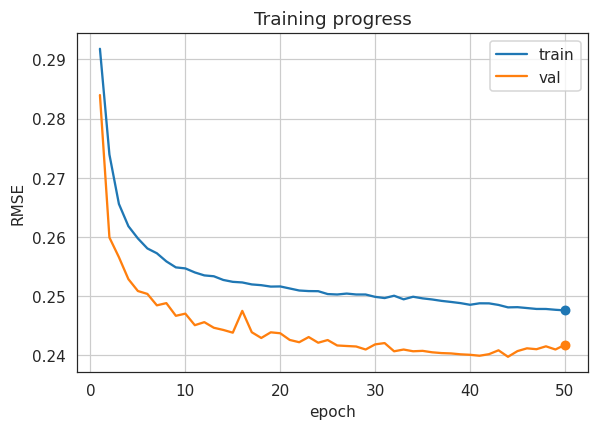

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2918 MAE=0.2288 R2=-0.0128 | "B": Acc=0.4662 Prec=0.2691 Rec=0.5763 F1=0.3669 AUROC=0.5024
VALID→ "R": RMSE=0.2840 MAE=0.1952 R2=-0.0056 | "B": Acc=0.3163 Prec=0.2817 Rec=0.9682 F1=0.4365 AUROC=0.6496


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2739 MAE=0.2125 R2=0.1076 | "B": Acc=0.4382 Prec=0.2792 Rec=0.6912 F1=0.3977 AUROC=0.5295
VALID→ "R": RMSE=0.2599 MAE=0.1902 R2=0.1578 | "B": Acc=0.5319 Prec=0.3438 Rec=0.7833 F1=0.4779 AUROC=0.6587


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2656 MAE=0.2038 R2=0.1612 | "B": Acc=0.4952 Prec=0.2890 Rec=0.6031 F1=0.3907 AUROC=0.5421
VALID→ "R": RMSE=0.2566 MAE=0.1833 R2=0.1792 | "B": Acc=0.6135 Prec=0.3633 Rec=0.5491 F1=0.4373 AUROC=0.6401


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2618 MAE=0.1999 R2=0.1848 | "B": Acc=0.4950 Prec=0.2832 Rec=0.5757 F1=0.3796 AUROC=0.5303
VALID→ "R": RMSE=0.2529 MAE=0.1845 R2=0.2028 | "B": Acc=0.5197 Prec=0.3330 Rec=0.7544 F1=0.4621 AUROC=0.6224
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25285_chp.pth


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2597 MAE=0.1972 R2=0.1976 | "B": Acc=0.4573 Prec=0.2794 Rec=0.6473 F1=0.3903 AUROC=0.5283
VALID→ "R": RMSE=0.2508 MAE=0.1816 R2=0.2154 | "B": Acc=0.4037 Prec=0.3010 Rec=0.8928 F1=0.4502 AUROC=0.5988
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25084_chp.pth


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2580 MAE=0.1968 R2=0.2080 | "B": Acc=0.4198 Prec=0.2754 Rec=0.7123 F1=0.3972 AUROC=0.5248
VALID→ "R": RMSE=0.2504 MAE=0.1798 R2=0.2185 | "B": Acc=0.3051 Prec=0.2716 Rec=0.9164 F1=0.4190 AUROC=0.5246
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25035_chp.pth


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2572 MAE=0.1969 R2=0.2130 | "B": Acc=0.3870 Prec=0.2711 Rec=0.7605 F1=0.3997 AUROC=0.5153
VALID→ "R": RMSE=0.2484 MAE=0.1802 R2=0.2305 | "B": Acc=0.2762 Prec=0.2687 Rec=0.9568 F1=0.4196 AUROC=0.4924
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24842_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2559 MAE=0.1940 R2=0.2214 | "B": Acc=0.3957 Prec=0.2722 Rec=0.7478 F1=0.3991 AUROC=0.5200
VALID→ "R": RMSE=0.2488 MAE=0.1771 R2=0.2282 | "B": Acc=0.2725 Prec=0.2717 Rec=0.9879 F1=0.4262 AUROC=0.4774


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2548 MAE=0.1936 R2=0.2276 | "B": Acc=0.3881 Prec=0.2707 Rec=0.7559 F1=0.3987 AUROC=0.5176
VALID→ "R": RMSE=0.2467 MAE=0.1774 R2=0.2414 | "B": Acc=0.2718 Prec=0.2703 Rec=0.9786 F1=0.4236 AUROC=0.4585
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24665_chp.pth


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2547 MAE=0.1949 R2=0.2286 | "B": Acc=0.3902 Prec=0.2717 Rec=0.7570 F1=0.3999 AUROC=0.5184
VALID→ "R": RMSE=0.2470 MAE=0.1788 R2=0.2392 | "B": Acc=0.3192 Prec=0.2571 Rec=0.7882 F1=0.3877 AUROC=0.4695


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2540 MAE=0.1926 R2=0.2327 | "B": Acc=0.4058 Prec=0.2736 Rec=0.7336 F1=0.3986 AUROC=0.5241
VALID→ "R": RMSE=0.2451 MAE=0.1773 R2=0.2512 | "B": Acc=0.2872 Prec=0.2685 Rec=0.9319 F1=0.4169 AUROC=0.4704
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24506_chp.pth


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2535 MAE=0.1943 R2=0.2358 | "B": Acc=0.3893 Prec=0.2717 Rec=0.7588 F1=0.4001 AUROC=0.5184
VALID→ "R": RMSE=0.2456 MAE=0.1770 R2=0.2480 | "B": Acc=0.3235 Prec=0.2622 Rec=0.8127 F1=0.3965 AUROC=0.4742


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2533 MAE=0.1919 R2=0.2366 | "B": Acc=0.4105 Prec=0.2743 Rec=0.7268 F1=0.3982 AUROC=0.5245
VALID→ "R": RMSE=0.2446 MAE=0.1774 R2=0.2538 | "B": Acc=0.3434 Prec=0.2659 Rec=0.7955 F1=0.3985 AUROC=0.4760
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24463_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2527 MAE=0.1935 R2=0.2404 | "B": Acc=0.4045 Prec=0.2742 Rec=0.7404 F1=0.4002 AUROC=0.5232
VALID→ "R": RMSE=0.2443 MAE=0.1783 R2=0.2561 | "B": Acc=0.4011 Prec=0.2641 Rec=0.6665 F1=0.3783 AUROC=0.4841
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24426_chp.pth


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2524 MAE=0.1922 R2=0.2423 | "B": Acc=0.4198 Prec=0.2761 Rec=0.7164 F1=0.3986 AUROC=0.5278
VALID→ "R": RMSE=0.2438 MAE=0.1769 R2=0.2589 | "B": Acc=0.3924 Prec=0.2696 Rec=0.7150 F1=0.3916 AUROC=0.4955
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24380_chp.pth


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2523 MAE=0.1925 R2=0.2429 | "B": Acc=0.4183 Prec=0.2751 Rec=0.7141 F1=0.3972 AUROC=0.5253
VALID→ "R": RMSE=0.2475 MAE=0.1736 R2=0.2363 | "B": Acc=0.3883 Prec=0.2695 Rec=0.7232 F1=0.3927 AUROC=0.4994


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2520 MAE=0.1918 R2=0.2449 | "B": Acc=0.4175 Prec=0.2751 Rec=0.7159 F1=0.3974 AUROC=0.5256
VALID→ "R": RMSE=0.2439 MAE=0.1773 R2=0.2584 | "B": Acc=0.4181 Prec=0.2654 Rec=0.6380 F1=0.3748 AUROC=0.4915


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2518 MAE=0.1907 R2=0.2457 | "B": Acc=0.4165 Prec=0.2740 Rec=0.7120 F1=0.3957 AUROC=0.5230
VALID→ "R": RMSE=0.2429 MAE=0.1770 R2=0.2643 | "B": Acc=0.3346 Prec=0.2670 Rec=0.8212 F1=0.4030 AUROC=0.4875
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24290_chp.pth


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2516 MAE=0.1920 R2=0.2471 | "B": Acc=0.4012 Prec=0.2708 Rec=0.7274 F1=0.3947 AUROC=0.5154
VALID→ "R": RMSE=0.2439 MAE=0.1754 R2=0.2585 | "B": Acc=0.3577 Prec=0.2581 Rec=0.7193 F1=0.3798 AUROC=0.4761


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2516 MAE=0.1922 R2=0.2470 | "B": Acc=0.4022 Prec=0.2695 Rec=0.7172 F1=0.3917 AUROC=0.5115
VALID→ "R": RMSE=0.2437 MAE=0.1752 R2=0.2595 | "B": Acc=0.3859 Prec=0.2615 Rec=0.6829 F1=0.3782 AUROC=0.4820


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2513 MAE=0.1919 R2=0.2490 | "B": Acc=0.4033 Prec=0.2676 Rec=0.7042 F1=0.3878 AUROC=0.5066
VALID→ "R": RMSE=0.2426 MAE=0.1774 R2=0.2663 | "B": Acc=0.3651 Prec=0.2540 Rec=0.6824 F1=0.3702 AUROC=0.4664
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24257_chp.pth


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2509 MAE=0.1905 R2=0.2511 | "B": Acc=0.4033 Prec=0.2680 Rec=0.7068 F1=0.3887 AUROC=0.5075
VALID→ "R": RMSE=0.2422 MAE=0.1768 R2=0.2687 | "B": Acc=0.3390 Prec=0.2558 Rec=0.7420 F1=0.3804 AUROC=0.4650
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24218_chp.pth


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2508 MAE=0.1911 R2=0.2517 | "B": Acc=0.3894 Prec=0.2623 Rec=0.7035 F1=0.3821 AUROC=0.4928
VALID→ "R": RMSE=0.2431 MAE=0.1751 R2=0.2634 | "B": Acc=0.3391 Prec=0.2493 Rec=0.7042 F1=0.3682 AUROC=0.4584


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2508 MAE=0.1911 R2=0.2518 | "B": Acc=0.3885 Prec=0.2612 Rec=0.6993 F1=0.3803 AUROC=0.4895
VALID→ "R": RMSE=0.2421 MAE=0.1766 R2=0.2692 | "B": Acc=0.3380 Prec=0.2473 Rec=0.6953 F1=0.3648 AUROC=0.4538
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24210_chp.pth


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2503 MAE=0.1900 R2=0.2547 | "B": Acc=0.3859 Prec=0.2611 Rec=0.7039 F1=0.3809 AUROC=0.4897
VALID→ "R": RMSE=0.2426 MAE=0.1753 R2=0.2664 | "B": Acc=0.3370 Prec=0.2474 Rec=0.6977 F1=0.3653 AUROC=0.4568


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2503 MAE=0.1903 R2=0.2551 | "B": Acc=0.3889 Prec=0.2620 Rec=0.7031 F1=0.3818 AUROC=0.4926
VALID→ "R": RMSE=0.2416 MAE=0.1775 R2=0.2720 | "B": Acc=0.3383 Prec=0.2504 Rec=0.7120 F1=0.3705 AUROC=0.4620
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24163_chp.pth


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2504 MAE=0.1911 R2=0.2542 | "B": Acc=0.3723 Prec=0.2585 Rec=0.7165 F1=0.3799 AUROC=0.4835
VALID→ "R": RMSE=0.2415 MAE=0.1771 R2=0.2725 | "B": Acc=0.3316 Prec=0.2425 Rec=0.6799 F1=0.3575 AUROC=0.4434
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24155_chp.pth


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2503 MAE=0.1909 R2=0.2551 | "B": Acc=0.3697 Prec=0.2551 Rec=0.7023 F1=0.3743 AUROC=0.4748
VALID→ "R": RMSE=0.2415 MAE=0.1767 R2=0.2730 | "B": Acc=0.3217 Prec=0.2372 Rec=0.6682 F1=0.3501 AUROC=0.4364
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24146_chp.pth


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2503 MAE=0.1909 R2=0.2551 | "B": Acc=0.3631 Prec=0.2525 Rec=0.7006 F1=0.3712 AUROC=0.4669
VALID→ "R": RMSE=0.2410 MAE=0.1777 R2=0.2761 | "B": Acc=0.3241 Prec=0.2344 Rec=0.6495 F1=0.3445 AUROC=0.4320
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24095_chp.pth


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2499 MAE=0.1904 R2=0.2575 | "B": Acc=0.3722 Prec=0.2538 Rec=0.6907 F1=0.3713 AUROC=0.4722
VALID→ "R": RMSE=0.2418 MAE=0.1752 R2=0.2709 | "B": Acc=0.3161 Prec=0.2396 Rec=0.6906 F1=0.3558 AUROC=0.4459


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2497 MAE=0.1898 R2=0.2587 | "B": Acc=0.3723 Prec=0.2542 Rec=0.6924 F1=0.3719 AUROC=0.4725
VALID→ "R": RMSE=0.2420 MAE=0.1747 R2=0.2695 | "B": Acc=0.3029 Prec=0.2397 Rec=0.7134 F1=0.3588 AUROC=0.4493


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2500 MAE=0.1907 R2=0.2564 | "B": Acc=0.3756 Prec=0.2556 Rec=0.6940 F1=0.3737 AUROC=0.4777
VALID→ "R": RMSE=0.2407 MAE=0.1782 R2=0.2779 | "B": Acc=0.3306 Prec=0.2382 Rec=0.6588 F1=0.3499 AUROC=0.4437
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24065_chp.pth


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2494 MAE=0.1896 R2=0.2600 | "B": Acc=0.3687 Prec=0.2550 Rec=0.7038 F1=0.3744 AUROC=0.4770
VALID→ "R": RMSE=0.2409 MAE=0.1763 R2=0.2761 | "B": Acc=0.3060 Prec=0.2400 Rec=0.7099 F1=0.3587 AUROC=0.4494


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2499 MAE=0.1909 R2=0.2574 | "B": Acc=0.3640 Prec=0.2544 Rec=0.7098 F1=0.3746 AUROC=0.4749
VALID→ "R": RMSE=0.2407 MAE=0.1765 R2=0.2779 | "B": Acc=0.2992 Prec=0.2388 Rec=0.7140 F1=0.3579 AUROC=0.4445


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2496 MAE=0.1909 R2=0.2590 | "B": Acc=0.3595 Prec=0.2514 Rec=0.7013 F1=0.3701 AUROC=0.4673
VALID→ "R": RMSE=0.2407 MAE=0.1763 R2=0.2775 | "B": Acc=0.2933 Prec=0.2329 Rec=0.6906 F1=0.3483 AUROC=0.4300


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2494 MAE=0.1906 R2=0.2601 | "B": Acc=0.3596 Prec=0.2519 Rec=0.7038 F1=0.3710 AUROC=0.4688
VALID→ "R": RMSE=0.2405 MAE=0.1763 R2=0.2789 | "B": Acc=0.2987 Prec=0.2336 Rec=0.6861 F1=0.3486 AUROC=0.4339
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24048_chp.pth


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2492 MAE=0.1901 R2=0.2615 | "B": Acc=0.3610 Prec=0.2510 Rec=0.6962 F1=0.3690 AUROC=0.4661
VALID→ "R": RMSE=0.2403 MAE=0.1760 R2=0.2797 | "B": Acc=0.2921 Prec=0.2371 Rec=0.7164 F1=0.3563 AUROC=0.4390
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24035_chp.pth


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2490 MAE=0.1898 R2=0.2626 | "B": Acc=0.3599 Prec=0.2501 Rec=0.6928 F1=0.3675 AUROC=0.4635
VALID→ "R": RMSE=0.2403 MAE=0.1758 R2=0.2801 | "B": Acc=0.2906 Prec=0.2362 Rec=0.7137 F1=0.3549 AUROC=0.4339
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24029_chp.pth


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2488 MAE=0.1896 R2=0.2638 | "B": Acc=0.3616 Prec=0.2514 Rec=0.6971 F1=0.3695 AUROC=0.4677
VALID→ "R": RMSE=0.2401 MAE=0.1759 R2=0.2810 | "B": Acc=0.3078 Prec=0.2358 Rec=0.6834 F1=0.3507 AUROC=0.4411
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24014_chp.pth


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2485 MAE=0.1892 R2=0.2654 | "B": Acc=0.3549 Prec=0.2493 Rec=0.6979 F1=0.3674 AUROC=0.4613
VALID→ "R": RMSE=0.2401 MAE=0.1757 R2=0.2814 | "B": Acc=0.2891 Prec=0.2358 Rec=0.7139 F1=0.3545 AUROC=0.4310
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24006_chp.pth


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2488 MAE=0.1895 R2=0.2640 | "B": Acc=0.3571 Prec=0.2507 Rec=0.7015 F1=0.3693 AUROC=0.4651
VALID→ "R": RMSE=0.2399 MAE=0.1757 R2=0.2824 | "B": Acc=0.2874 Prec=0.2373 Rec=0.7254 F1=0.3576 AUROC=0.4337
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23990_chp.pth


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2488 MAE=0.1898 R2=0.2640 | "B": Acc=0.3558 Prec=0.2497 Rec=0.6985 F1=0.3679 AUROC=0.4626
VALID→ "R": RMSE=0.2402 MAE=0.1748 R2=0.2808 | "B": Acc=0.2756 Prec=0.2394 Rec=0.7572 F1=0.3637 AUROC=0.4292


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2485 MAE=0.1889 R2=0.2656 | "B": Acc=0.3502 Prec=0.2487 Rec=0.7033 F1=0.3674 AUROC=0.4593
VALID→ "R": RMSE=0.2408 MAE=0.1739 R2=0.2769 | "B": Acc=0.2791 Prec=0.2391 Rec=0.7495 F1=0.3625 AUROC=0.4342


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2481 MAE=0.1882 R2=0.2680 | "B": Acc=0.3466 Prec=0.2492 Rec=0.7129 F1=0.3694 AUROC=0.4600
VALID→ "R": RMSE=0.2397 MAE=0.1751 R2=0.2835 | "B": Acc=0.2813 Prec=0.2376 Rec=0.7370 F1=0.3593 AUROC=0.4265
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23972_chp.pth


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2481 MAE=0.1888 R2=0.2678 | "B": Acc=0.3461 Prec=0.2496 Rec=0.7163 F1=0.3702 AUROC=0.4615
VALID→ "R": RMSE=0.2407 MAE=0.1739 R2=0.2777 | "B": Acc=0.2760 Prec=0.2370 Rec=0.7424 F1=0.3593 AUROC=0.4230


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2480 MAE=0.1883 R2=0.2687 | "B": Acc=0.3446 Prec=0.2484 Rec=0.7118 F1=0.3683 AUROC=0.4573
VALID→ "R": RMSE=0.2412 MAE=0.1733 R2=0.2749 | "B": Acc=0.2764 Prec=0.2364 Rec=0.7380 F1=0.3581 AUROC=0.4208


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2478 MAE=0.1883 R2=0.2696 | "B": Acc=0.3442 Prec=0.2486 Rec=0.7140 F1=0.3688 AUROC=0.4581
VALID→ "R": RMSE=0.2410 MAE=0.1733 R2=0.2758 | "B": Acc=0.2734 Prec=0.2385 Rec=0.7555 F1=0.3625 AUROC=0.4235


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2478 MAE=0.1883 R2=0.2696 | "B": Acc=0.3391 Prec=0.2483 Rec=0.7213 F1=0.3694 AUROC=0.4549
VALID→ "R": RMSE=0.2415 MAE=0.1729 R2=0.2728 | "B": Acc=0.2672 Prec=0.2389 Rec=0.7688 F1=0.3646 AUROC=0.4179


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2477 MAE=0.1882 R2=0.2704 | "B": Acc=0.3360 Prec=0.2492 Rec=0.7326 F1=0.3719 AUROC=0.4567
VALID→ "R": RMSE=0.2410 MAE=0.1732 R2=0.2761 | "B": Acc=0.2735 Prec=0.2372 Rec=0.7473 F1=0.3600 AUROC=0.4152


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2476 MAE=0.1879 R2=0.2710 | "B": Acc=0.3375 Prec=0.2480 Rec=0.7227 F1=0.3693 AUROC=0.4530
VALID→ "R": RMSE=0.2417 MAE=0.1724 R2=0.2713 | "B": Acc=0.2660 Prec=0.2415 Rec=0.7865 F1=0.3695 AUROC=0.4188
Early stopping at epoch 50
✅ Final best model (_fin) saved: AAPL_0.23972_fin.pth
Delete variables to free memory...


[I 2025-09-21 21:06:23,779] Trial 1 finished with value: 0.23971986770629883 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3415134545472035, 'DROPOUT_LONG': 0.24816720951890858, 'ATT_DROPOUT': 0.0718288110815528, 'INITIAL_LR': 0.00020330513047952525, 'ETA_MIN': 2.229337954085058e-06, 'WEIGHT_DECAY': 0.005618045244987561, 'CLIPNORM': 1.5533984125092046}. Best is trial 1 with value: 0.23971986770629883.



▶ Trial 2 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.08533800566216, 'DROPOUT_LONG': 0.17501876888435014, 'ATT_DROPOUT': 0.11395641025161804, 'INITIAL_LR': 0.00037112936798396073, 'ETA_MIN': 1.2661257120438949e-06, 'WEIGHT_DECAY': 0.00013952752317438418, 'CLIPNORM': 1.391668362345588}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


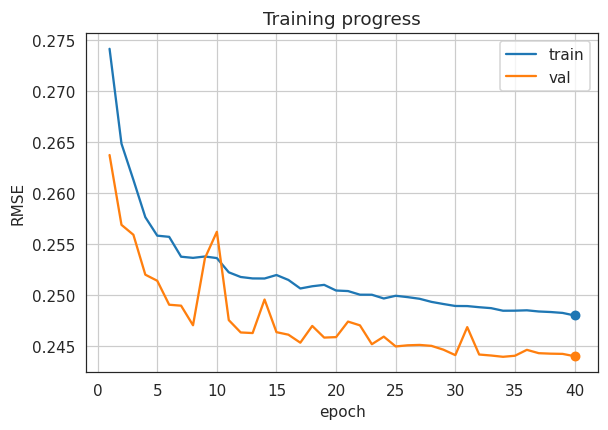

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2741 MAE=0.2117 R2=0.1192 | "B": Acc=0.6671 Prec=0.2231 Rec=0.0725 F1=0.1095 AUROC=0.4376
VALID→ "R": RMSE=0.2637 MAE=0.2156 R2=0.1674 | "B": Acc=0.7053 Prec=0.8889 Rec=0.0016 F1=0.0033 AUROC=0.4104
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26373_chp.pth


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2648 MAE=0.2046 R2=0.1779 | "B": Acc=0.6568 Prec=0.2666 Rec=0.1237 F1=0.1690 AUROC=0.4814
VALID→ "R": RMSE=0.2569 MAE=0.2030 R2=0.2100 | "B": Acc=0.7052 Prec=0.7766 Rec=0.0016 F1=0.0033 AUROC=0.3369
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25689_chp.pth


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2613 MAE=0.2016 R2=0.1998 | "B": Acc=0.6445 Prec=0.2735 Rec=0.1570 F1=0.1995 AUROC=0.4886
VALID→ "R": RMSE=0.2559 MAE=0.1860 R2=0.2160 | "B": Acc=0.7049 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3311
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25592_chp.pth


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2576 MAE=0.1983 R2=0.2220 | "B": Acc=0.6639 Prec=0.2610 Rec=0.1044 F1=0.1491 AUROC=0.4765
VALID→ "R": RMSE=0.2520 MAE=0.1958 R2=0.2398 | "B": Acc=0.7045 Prec=0.0085 Rec=0.0000 F1=0.0000 AUROC=0.3868
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25201_chp.pth


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2558 MAE=0.1960 R2=0.2329 | "B": Acc=0.6625 Prec=0.2531 Rec=0.1005 F1=0.1439 AUROC=0.4701
VALID→ "R": RMSE=0.2514 MAE=0.1954 R2=0.2433 | "B": Acc=0.7047 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.3266
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25141_chp.pth


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2557 MAE=0.1971 R2=0.2336 | "B": Acc=0.6720 Prec=0.2350 Rec=0.0720 F1=0.1102 AUROC=0.4548
VALID→ "R": RMSE=0.2491 MAE=0.1883 R2=0.2574 | "B": Acc=0.7043 Prec=0.0267 Rec=0.0001 F1=0.0001 AUROC=0.3564
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24907_chp.pth


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2538 MAE=0.1944 R2=0.2452 | "B": Acc=0.6628 Prec=0.2327 Rec=0.0850 F1=0.1245 AUROC=0.4484
VALID→ "R": RMSE=0.2490 MAE=0.1945 R2=0.2580 | "B": Acc=0.7044 Prec=0.0189 Rec=0.0000 F1=0.0001 AUROC=0.3480
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24897_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2537 MAE=0.1945 R2=0.2459 | "B": Acc=0.6692 Prec=0.2327 Rec=0.0750 F1=0.1135 AUROC=0.4464
VALID→ "R": RMSE=0.2471 MAE=0.1916 R2=0.2693 | "B": Acc=0.7044 Prec=0.0286 Rec=0.0001 F1=0.0001 AUROC=0.3807
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24706_chp.pth


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2538 MAE=0.1954 R2=0.2451 | "B": Acc=0.6697 Prec=0.2485 Rec=0.0843 F1=0.1259 AUROC=0.4601
VALID→ "R": RMSE=0.2536 MAE=0.1840 R2=0.2300 | "B": Acc=0.7043 Prec=0.0207 Rec=0.0000 F1=0.0001 AUROC=0.4027


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2536 MAE=0.1956 R2=0.2460 | "B": Acc=0.6685 Prec=0.2621 Rec=0.0964 F1=0.1410 AUROC=0.4712
VALID→ "R": RMSE=0.2562 MAE=0.1827 R2=0.2142 | "B": Acc=0.7042 Prec=0.0446 Rec=0.0001 F1=0.0002 AUROC=0.4227


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2522 MAE=0.1932 R2=0.2543 | "B": Acc=0.6696 Prec=0.2569 Rec=0.0904 F1=0.1337 AUROC=0.4638
VALID→ "R": RMSE=0.2476 MAE=0.1867 R2=0.2664 | "B": Acc=0.7044 Prec=0.0876 Rec=0.0002 F1=0.0004 AUROC=0.4269


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2518 MAE=0.1930 R2=0.2570 | "B": Acc=0.6682 Prec=0.2599 Rec=0.0953 F1=0.1395 AUROC=0.4615
VALID→ "R": RMSE=0.2464 MAE=0.1908 R2=0.2735 | "B": Acc=0.7046 Prec=0.4231 Rec=0.0030 F1=0.0059 AUROC=0.4209
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24635_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2516 MAE=0.1933 R2=0.2578 | "B": Acc=0.6714 Prec=0.2752 Rec=0.1009 F1=0.1476 AUROC=0.4711
VALID→ "R": RMSE=0.2463 MAE=0.1883 R2=0.2739 | "B": Acc=0.7048 Prec=0.4926 Rec=0.0078 F1=0.0154 AUROC=0.4382
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24629_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2516 MAE=0.1928 R2=0.2579 | "B": Acc=0.6770 Prec=0.2828 Rec=0.0944 F1=0.1416 AUROC=0.4750
VALID→ "R": RMSE=0.2496 MAE=0.1822 R2=0.2544 | "B": Acc=0.7051 Prec=0.5137 Rec=0.0135 F1=0.0263 AUROC=0.4502


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2520 MAE=0.1941 R2=0.2558 | "B": Acc=0.6610 Prec=0.2809 Rec=0.1292 F1=0.1770 AUROC=0.4770
VALID→ "R": RMSE=0.2464 MAE=0.1852 R2=0.2733 | "B": Acc=0.7038 Prec=0.4528 Rec=0.0178 F1=0.0343 AUROC=0.4658


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2515 MAE=0.1930 R2=0.2587 | "B": Acc=0.6595 Prec=0.3009 Rec=0.1564 F1=0.2058 AUROC=0.4932
VALID→ "R": RMSE=0.2461 MAE=0.1852 R2=0.2748 | "B": Acc=0.7021 Prec=0.4585 Rec=0.0526 F1=0.0943 AUROC=0.4956
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24613_chp.pth


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2507 MAE=0.1917 R2=0.2636 | "B": Acc=0.6649 Prec=0.3140 Rec=0.1584 F1=0.2105 AUROC=0.5010
VALID→ "R": RMSE=0.2453 MAE=0.1895 R2=0.2794 | "B": Acc=0.7025 Prec=0.4575 Rec=0.0441 F1=0.0804 AUROC=0.4901
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24535_chp.pth


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2509 MAE=0.1926 R2=0.2623 | "B": Acc=0.6677 Prec=0.3160 Rec=0.1527 F1=0.2060 AUROC=0.4990
VALID→ "R": RMSE=0.2470 MAE=0.1833 R2=0.2697 | "B": Acc=0.7056 Prec=0.5110 Rec=0.0582 F1=0.1045 AUROC=0.5198


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2510 MAE=0.1933 R2=0.2615 | "B": Acc=0.6617 Prec=0.3182 Rec=0.1741 F1=0.2251 AUROC=0.5063
VALID→ "R": RMSE=0.2458 MAE=0.1841 R2=0.2765 | "B": Acc=0.7063 Prec=0.5148 Rec=0.0841 F1=0.1446 AUROC=0.5411


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2505 MAE=0.1919 R2=0.2648 | "B": Acc=0.6640 Prec=0.3294 Rec=0.1843 F1=0.2364 AUROC=0.5148
VALID→ "R": RMSE=0.2459 MAE=0.1842 R2=0.2762 | "B": Acc=0.7055 Prec=0.5061 Rec=0.0888 F1=0.1510 AUROC=0.5644


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2504 MAE=0.1916 R2=0.2651 | "B": Acc=0.6656 Prec=0.3351 Rec=0.1885 F1=0.2413 AUROC=0.5194
VALID→ "R": RMSE=0.2474 MAE=0.1814 R2=0.2672 | "B": Acc=0.7016 Prec=0.4648 Rec=0.0727 F1=0.1258 AUROC=0.5334


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2501 MAE=0.1915 R2=0.2672 | "B": Acc=0.6688 Prec=0.3308 Rec=0.1699 F1=0.2245 AUROC=0.5134
VALID→ "R": RMSE=0.2470 MAE=0.1823 R2=0.2694 | "B": Acc=0.7047 Prec=0.4975 Rec=0.0564 F1=0.1013 AUROC=0.5383


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2500 MAE=0.1919 R2=0.2672 | "B": Acc=0.6655 Prec=0.3340 Rec=0.1868 F1=0.2396 AUROC=0.5191
VALID→ "R": RMSE=0.2452 MAE=0.1842 R2=0.2803 | "B": Acc=0.7018 Prec=0.4636 Rec=0.0672 F1=0.1174 AUROC=0.5447
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24520_chp.pth


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2497 MAE=0.1911 R2=0.2694 | "B": Acc=0.6625 Prec=0.3341 Rec=0.1977 F1=0.2484 AUROC=0.5184
VALID→ "R": RMSE=0.2459 MAE=0.1821 R2=0.2759 | "B": Acc=0.6987 Prec=0.4515 Rec=0.0972 F1=0.1599 AUROC=0.5437


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2499 MAE=0.1921 R2=0.2678 | "B": Acc=0.6627 Prec=0.3387 Rec=0.2055 F1=0.2558 AUROC=0.5230
VALID→ "R": RMSE=0.2450 MAE=0.1833 R2=0.2816 | "B": Acc=0.7011 Prec=0.4707 Rec=0.1027 F1=0.1686 AUROC=0.5649
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24498_chp.pth


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2498 MAE=0.1914 R2=0.2686 | "B": Acc=0.6610 Prec=0.3451 Rec=0.2247 F1=0.2722 AUROC=0.5310
VALID→ "R": RMSE=0.2451 MAE=0.1833 R2=0.2809 | "B": Acc=0.7026 Prec=0.4815 Rec=0.1018 F1=0.1681 AUROC=0.5725


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2497 MAE=0.1911 R2=0.2695 | "B": Acc=0.6728 Prec=0.3602 Rec=0.2059 F1=0.2620 AUROC=0.5384
VALID→ "R": RMSE=0.2451 MAE=0.1828 R2=0.2807 | "B": Acc=0.7043 Prec=0.4953 Rec=0.1061 F1=0.1747 AUROC=0.5860


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2493 MAE=0.1907 R2=0.2713 | "B": Acc=0.6642 Prec=0.3509 Rec=0.2238 F1=0.2733 AUROC=0.5381
VALID→ "R": RMSE=0.2450 MAE=0.1821 R2=0.2812 | "B": Acc=0.6995 Prec=0.4653 Rec=0.1227 F1=0.1942 AUROC=0.5789


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2491 MAE=0.1906 R2=0.2725 | "B": Acc=0.6573 Prec=0.3476 Rec=0.2448 F1=0.2873 AUROC=0.5389
VALID→ "R": RMSE=0.2447 MAE=0.1820 R2=0.2834 | "B": Acc=0.6983 Prec=0.4625 Rec=0.1387 F1=0.2134 AUROC=0.5781
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24466_chp.pth


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2489 MAE=0.1905 R2=0.2736 | "B": Acc=0.6642 Prec=0.3495 Rec=0.2208 F1=0.2707 AUROC=0.5380
VALID→ "R": RMSE=0.2441 MAE=0.1833 R2=0.2866 | "B": Acc=0.6981 Prec=0.4648 Rec=0.1526 F1=0.2297 AUROC=0.5831
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24413_chp.pth


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2489 MAE=0.1910 R2=0.2737 | "B": Acc=0.6657 Prec=0.3569 Rec=0.2306 F1=0.2802 AUROC=0.5462
VALID→ "R": RMSE=0.2469 MAE=0.1802 R2=0.2704 | "B": Acc=0.7067 Prec=0.5118 Rec=0.1313 F1=0.2090 AUROC=0.6098


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2488 MAE=0.1901 R2=0.2744 | "B": Acc=0.6701 Prec=0.3606 Rec=0.2192 F1=0.2727 AUROC=0.5497
VALID→ "R": RMSE=0.2442 MAE=0.1828 R2=0.2862 | "B": Acc=0.6995 Prec=0.4547 Rec=0.0913 F1=0.1521 AUROC=0.5761


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2487 MAE=0.1903 R2=0.2749 | "B": Acc=0.6560 Prec=0.3502 Rec=0.2562 F1=0.2959 AUROC=0.5448
VALID→ "R": RMSE=0.2441 MAE=0.1822 R2=0.2868 | "B": Acc=0.7037 Prec=0.4921 Rec=0.1241 F1=0.1982 AUROC=0.5953
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24409_chp.pth


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2485 MAE=0.1901 R2=0.2764 | "B": Acc=0.6697 Prec=0.3613 Rec=0.2224 F1=0.2753 AUROC=0.5500
VALID→ "R": RMSE=0.2440 MAE=0.1829 R2=0.2875 | "B": Acc=0.7018 Prec=0.4807 Rec=0.1298 F1=0.2044 AUROC=0.5881
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24397_chp.pth


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2485 MAE=0.1902 R2=0.2763 | "B": Acc=0.6654 Prec=0.3619 Rec=0.2435 F1=0.2911 AUROC=0.5531
VALID→ "R": RMSE=0.2441 MAE=0.1827 R2=0.2869 | "B": Acc=0.7051 Prec=0.5013 Rec=0.1394 F1=0.2181 AUROC=0.6073


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2485 MAE=0.1898 R2=0.2761 | "B": Acc=0.6722 Prec=0.3711 Rec=0.2331 F1=0.2863 AUROC=0.5605
VALID→ "R": RMSE=0.2446 MAE=0.1824 R2=0.2835 | "B": Acc=0.7099 Prec=0.5330 Rec=0.1376 F1=0.2188 AUROC=0.6274


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2484 MAE=0.1894 R2=0.2768 | "B": Acc=0.6722 Prec=0.3754 Rec=0.2439 F1=0.2957 AUROC=0.5682
VALID→ "R": RMSE=0.2443 MAE=0.1826 R2=0.2854 | "B": Acc=0.7068 Prec=0.5105 Rec=0.1544 F1=0.2370 AUROC=0.6312


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2484 MAE=0.1893 R2=0.2771 | "B": Acc=0.6804 Prec=0.3854 Rec=0.2236 F1=0.2830 AUROC=0.5735
VALID→ "R": RMSE=0.2443 MAE=0.1826 R2=0.2857 | "B": Acc=0.7068 Prec=0.5141 Rec=0.1180 F1=0.1920 AUROC=0.6232


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2483 MAE=0.1894 R2=0.2776 | "B": Acc=0.6851 Prec=0.3925 Rec=0.2124 F1=0.2756 AUROC=0.5750
VALID→ "R": RMSE=0.2443 MAE=0.1824 R2=0.2858 | "B": Acc=0.7075 Prec=0.5237 Rec=0.0989 F1=0.1664 AUROC=0.6276


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2480 MAE=0.1896 R2=0.2791 | "B": Acc=0.6828 Prec=0.3864 Rec=0.2113 F1=0.2732 AUROC=0.5731
VALID→ "R": RMSE=0.2440 MAE=0.1822 R2=0.2872 | "B": Acc=0.7075 Prec=0.5265 Rec=0.0891 F1=0.1525 AUROC=0.6351
Early stopping at epoch 40
✅ Final best model (_fin) saved: AAPL_0.24397_fin.pth
Delete variables to free memory...


[I 2025-09-21 21:44:46,382] Trial 2 finished with value: 0.24396806955337524 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.08533800566216, 'DROPOUT_LONG': 0.17501876888435014, 'ATT_DROPOUT': 0.11395641025161804, 'INITIAL_LR': 0.00037112936798396073, 'ETA_MIN': 1.2661257120438949e-06, 'WEIGHT_DECAY': 0.00013952752317438418, 'CLIPNORM': 1.391668362345588}. Best is trial 1 with value: 0.23971986770629883.



▶ Trial 3 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.1713120299526837, 'DROPOUT_LONG': 0.2737684434453018, 'ATT_DROPOUT': 0.30099467330688784, 'INITIAL_LR': 9.772897235784906e-05, 'ETA_MIN': 2.4230433428074217e-06, 'WEIGHT_DECAY': 0.00017674173080099563, 'CLIPNORM': 0.538494919905313}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


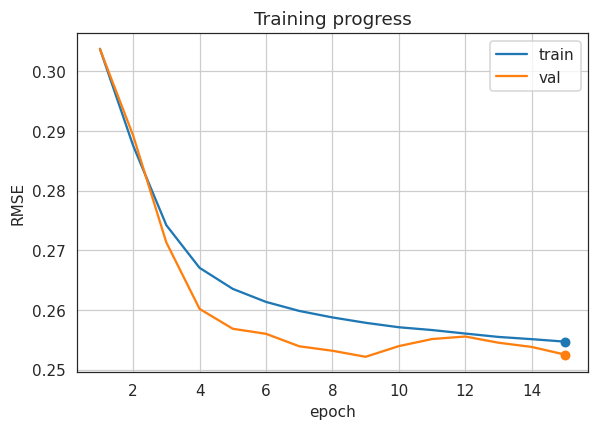

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3038 MAE=0.2415 R2=-0.0985 | "B": Acc=0.4736 Prec=0.2709 Rec=0.5504 F1=0.3631 AUROC=0.4964
VALID→ "R": RMSE=0.3037 MAE=0.2036 R2=-0.1354 | "B": Acc=0.2802 Prec=0.2802 Rec=0.9986 F1=0.4376 AUROC=0.4079


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2875 MAE=0.2263 R2=0.0158 | "B": Acc=0.4179 Prec=0.2724 Rec=0.6792 F1=0.3889 AUROC=0.4984
VALID→ "R": RMSE=0.2892 MAE=0.1985 R2=-0.0297 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.3834


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2742 MAE=0.2137 R2=0.1050 | "B": Acc=0.4061 Prec=0.2743 Rec=0.7161 F1=0.3967 AUROC=0.5045
VALID→ "R": RMSE=0.2713 MAE=0.1918 R2=0.0940 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.5275


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2671 MAE=0.2062 R2=0.1511 | "B": Acc=0.3953 Prec=0.2779 Rec=0.7621 F1=0.4073 AUROC=0.5165
VALID→ "R": RMSE=0.2602 MAE=0.1901 R2=0.1668 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.6255


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2635 MAE=0.2019 R2=0.1733 | "B": Acc=0.4069 Prec=0.2826 Rec=0.7636 F1=0.4125 AUROC=0.5326
VALID→ "R": RMSE=0.2568 MAE=0.1870 R2=0.1881 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.6495


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2613 MAE=0.2001 R2=0.1870 | "B": Acc=0.4055 Prec=0.2840 Rec=0.7761 F1=0.4158 AUROC=0.5392
VALID→ "R": RMSE=0.2560 MAE=0.1839 R2=0.1934 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.6701


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2598 MAE=0.1984 R2=0.1964 | "B": Acc=0.3982 Prec=0.2852 Rec=0.8015 F1=0.4207 AUROC=0.5480
VALID→ "R": RMSE=0.2539 MAE=0.1831 R2=0.2065 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.6834


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2587 MAE=0.1971 R2=0.2031 | "B": Acc=0.4069 Prec=0.2877 Rec=0.7966 F1=0.4228 AUROC=0.5551
VALID→ "R": RMSE=0.2532 MAE=0.1822 R2=0.2112 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.6887


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2578 MAE=0.1965 R2=0.2086 | "B": Acc=0.4013 Prec=0.2881 Rec=0.8129 F1=0.4254 AUROC=0.5600
VALID→ "R": RMSE=0.2521 MAE=0.1817 R2=0.2175 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.6972


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2571 MAE=0.1956 R2=0.2132 | "B": Acc=0.4112 Prec=0.2906 Rec=0.8048 F1=0.4270 AUROC=0.5671
VALID→ "R": RMSE=0.2539 MAE=0.1800 R2=0.2063 | "B": Acc=0.2805 Prec=0.2804 Rec=0.9999 F1=0.4380 AUROC=0.7016


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2566 MAE=0.1967 R2=0.2161 | "B": Acc=0.4016 Prec=0.2894 Rec=0.8212 F1=0.4280 AUROC=0.5671
VALID→ "R": RMSE=0.2551 MAE=0.1793 R2=0.1989 | "B": Acc=0.2810 Prec=0.2805 Rec=0.9995 F1=0.4381 AUROC=0.7058


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2560 MAE=0.1967 R2=0.2196 | "B": Acc=0.3952 Prec=0.2895 Rec=0.8379 F1=0.4303 AUROC=0.5722
VALID→ "R": RMSE=0.2555 MAE=0.1788 R2=0.1963 | "B": Acc=0.2821 Prec=0.2808 Rec=0.9994 F1=0.4384 AUROC=0.7175


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2555 MAE=0.1958 R2=0.2231 | "B": Acc=0.4024 Prec=0.2920 Rec=0.8367 F1=0.4329 AUROC=0.5808
VALID→ "R": RMSE=0.2545 MAE=0.1785 R2=0.2028 | "B": Acc=0.2838 Prec=0.2812 Rec=0.9988 F1=0.4389 AUROC=0.7162


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2551 MAE=0.1957 R2=0.2254 | "B": Acc=0.3980 Prec=0.2913 Rec=0.8430 F1=0.4330 AUROC=0.5804
VALID→ "R": RMSE=0.2538 MAE=0.1782 R2=0.2072 | "B": Acc=0.2851 Prec=0.2816 Rec=0.9986 F1=0.4393 AUROC=0.7176


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2547 MAE=0.1958 R2=0.2279 | "B": Acc=0.3960 Prec=0.2919 Rec=0.8524 F1=0.4349 AUROC=0.5856
VALID→ "R": RMSE=0.2525 MAE=0.1783 R2=0.2152 | "B": Acc=0.2825 Prec=0.2809 Rec=0.9992 F1=0.4385 AUROC=0.7140
Early stopping at epoch 15
✅ Final best model (_fin) saved: AAPL_0.25214_fin.pth
Delete variables to free memory...


[I 2025-09-21 22:03:07,698] Trial 3 finished with value: 0.2521449625492096 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.1713120299526837, 'DROPOUT_LONG': 0.2737684434453018, 'ATT_DROPOUT': 0.30099467330688784, 'INITIAL_LR': 9.772897235784906e-05, 'ETA_MIN': 2.4230433428074217e-06, 'WEIGHT_DECAY': 0.00017674173080099563, 'CLIPNORM': 0.538494919905313}. Best is trial 1 with value: 0.23971986770629883.



▶ Trial 4 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.06406270101670518, 'DROPOUT_LONG': 0.10327869244469204, 'ATT_DROPOUT': 0.2811579839531614, 'INITIAL_LR': 0.00013242063061113656, 'ETA_MIN': 5.305320557773728e-06, 'WEIGHT_DECAY': 0.00020043462492330002, 'CLIPNORM': 8.010539469377772}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


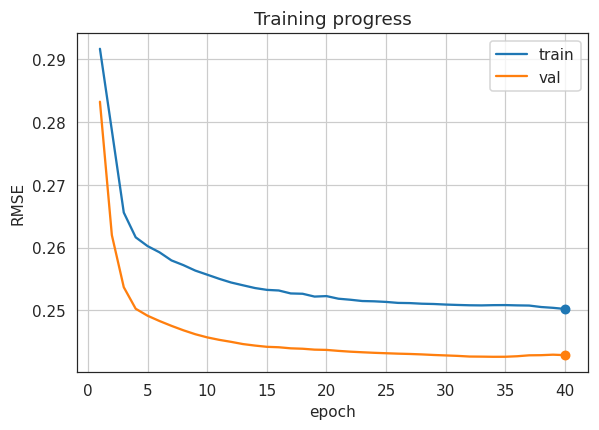

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2916 MAE=0.2308 R2=-0.0117 | "B": Acc=0.7271 Prec=0.3449 Rec=0.0188 F1=0.0357 AUROC=0.5247
VALID→ "R": RMSE=0.2832 MAE=0.2027 R2=-0.0002 | "B": Acc=0.7272 Prec=0.7449 Rec=0.0035 F1=0.0070 AUROC=0.6130


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2786 MAE=0.2204 R2=0.0765 | "B": Acc=0.7162 Prec=0.3892 Rec=0.1010 F1=0.1604 AUROC=0.5638
VALID→ "R": RMSE=0.2620 MAE=0.1924 R2=0.1442 | "B": Acc=0.7366 Prec=0.5484 Rec=0.2080 F1=0.3016 AUROC=0.6873


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2656 MAE=0.2038 R2=0.1611 | "B": Acc=0.6352 Prec=0.3634 Rec=0.4783 F1=0.4130 AUROC=0.6174
VALID→ "R": RMSE=0.2537 MAE=0.1908 R2=0.1975 | "B": Acc=0.6586 Prec=0.4213 Rec=0.6645 F1=0.5156 AUROC=0.7206


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2616 MAE=0.1992 R2=0.1859 | "B": Acc=0.5223 Prec=0.3247 Rec=0.7221 F1=0.4479 AUROC=0.6326
VALID→ "R": RMSE=0.2503 MAE=0.1891 R2=0.2191 | "B": Acc=0.5372 Prec=0.3557 Rec=0.8533 F1=0.5021 AUROC=0.7187


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2602 MAE=0.1978 R2=0.1946 | "B": Acc=0.4440 Prec=0.3029 Rec=0.8237 F1=0.4430 AUROC=0.6290
VALID→ "R": RMSE=0.2491 MAE=0.1878 R2=0.2261 | "B": Acc=0.3565 Prec=0.2952 Rec=0.9751 F1=0.4532 AUROC=0.7178


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2592 MAE=0.1967 R2=0.2007 | "B": Acc=0.4090 Prec=0.2956 Rec=0.8694 F1=0.4412 AUROC=0.6321
VALID→ "R": RMSE=0.2483 MAE=0.1872 R2=0.2313 | "B": Acc=0.3018 Prec=0.2806 Rec=0.9928 F1=0.4375 AUROC=0.7156


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2579 MAE=0.1959 R2=0.2086 | "B": Acc=0.4048 Prec=0.2951 Rec=0.8767 F1=0.4416 AUROC=0.6331
VALID→ "R": RMSE=0.2475 MAE=0.1860 R2=0.2360 | "B": Acc=0.2927 Prec=0.2781 Rec=0.9944 F1=0.4347 AUROC=0.7124


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2572 MAE=0.1953 R2=0.2132 | "B": Acc=0.3967 Prec=0.2929 Rec=0.8828 F1=0.4399 AUROC=0.6302
VALID→ "R": RMSE=0.2468 MAE=0.1852 R2=0.2404 | "B": Acc=0.2844 Prec=0.2761 Rec=0.9965 F1=0.4323 AUROC=0.7077


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2563 MAE=0.1948 R2=0.2185 | "B": Acc=0.3897 Prec=0.2912 Rec=0.8883 F1=0.4386 AUROC=0.6276
VALID→ "R": RMSE=0.2462 MAE=0.1845 R2=0.2442 | "B": Acc=0.2790 Prec=0.2748 Rec=0.9982 F1=0.4309 AUROC=0.7029


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2557 MAE=0.1943 R2=0.2225 | "B": Acc=0.3847 Prec=0.2899 Rec=0.8914 F1=0.4375 AUROC=0.6238
VALID→ "R": RMSE=0.2457 MAE=0.1840 R2=0.2473 | "B": Acc=0.2761 Prec=0.2741 Rec=0.9991 F1=0.4301 AUROC=0.6968


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2550 MAE=0.1938 R2=0.2265 | "B": Acc=0.3773 Prec=0.2879 Rec=0.8964 F1=0.4359 AUROC=0.6198
VALID→ "R": RMSE=0.2453 MAE=0.1833 R2=0.2497 | "B": Acc=0.2751 Prec=0.2738 Rec=0.9993 F1=0.4299 AUROC=0.6895


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2544 MAE=0.1934 R2=0.2300 | "B": Acc=0.3737 Prec=0.2868 Rec=0.8968 F1=0.4346 AUROC=0.6149
VALID→ "R": RMSE=0.2450 MAE=0.1827 R2=0.2517 | "B": Acc=0.2749 Prec=0.2738 Rec=0.9994 F1=0.4298 AUROC=0.6823


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2540 MAE=0.1927 R2=0.2327 | "B": Acc=0.3761 Prec=0.2869 Rec=0.8917 F1=0.4341 AUROC=0.6114
VALID→ "R": RMSE=0.2446 MAE=0.1827 R2=0.2538 | "B": Acc=0.2752 Prec=0.2738 Rec=0.9990 F1=0.4298 AUROC=0.6709


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2536 MAE=0.1925 R2=0.2354 | "B": Acc=0.3686 Prec=0.2849 Rec=0.8956 F1=0.4323 AUROC=0.6041
VALID→ "R": RMSE=0.2444 MAE=0.1825 R2=0.2553 | "B": Acc=0.2750 Prec=0.2738 Rec=0.9991 F1=0.4298 AUROC=0.6621


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2533 MAE=0.1920 R2=0.2371 | "B": Acc=0.3715 Prec=0.2853 Rec=0.8916 F1=0.4323 AUROC=0.6024
VALID→ "R": RMSE=0.2442 MAE=0.1823 R2=0.2565 | "B": Acc=0.2772 Prec=0.2742 Rec=0.9974 F1=0.4301 AUROC=0.6531


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2532 MAE=0.1917 R2=0.2377 | "B": Acc=0.3699 Prec=0.2845 Rec=0.8898 F1=0.4312 AUROC=0.5977
VALID→ "R": RMSE=0.2441 MAE=0.1817 R2=0.2569 | "B": Acc=0.2785 Prec=0.2744 Rec=0.9962 F1=0.4302 AUROC=0.6454


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2527 MAE=0.1923 R2=0.2405 | "B": Acc=0.3623 Prec=0.2829 Rec=0.8967 F1=0.4301 AUROC=0.5935
VALID→ "R": RMSE=0.2440 MAE=0.1820 R2=0.2579 | "B": Acc=0.2800 Prec=0.2746 Rec=0.9946 F1=0.4304 AUROC=0.6390
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24395_chp.pth


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2526 MAE=0.1917 R2=0.2408 | "B": Acc=0.3624 Prec=0.2827 Rec=0.8949 F1=0.4297 AUROC=0.5916
VALID→ "R": RMSE=0.2439 MAE=0.1815 R2=0.2583 | "B": Acc=0.2807 Prec=0.2747 Rec=0.9942 F1=0.4305 AUROC=0.6338
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24389_chp.pth


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2522 MAE=0.1924 R2=0.2435 | "B": Acc=0.3612 Prec=0.2828 Rec=0.8983 F1=0.4301 AUROC=0.5923
VALID→ "R": RMSE=0.2437 MAE=0.1819 R2=0.2592 | "B": Acc=0.2952 Prec=0.2773 Rec=0.9824 F1=0.4325 AUROC=0.6297
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24374_chp.pth


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2523 MAE=0.1913 R2=0.2431 | "B": Acc=0.3717 Prec=0.2840 Rec=0.8815 F1=0.4296 AUROC=0.5879
VALID→ "R": RMSE=0.2437 MAE=0.1811 R2=0.2595 | "B": Acc=0.2998 Prec=0.2783 Rec=0.9791 F1=0.4334 AUROC=0.6249
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24370_chp.pth


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2519 MAE=0.1922 R2=0.2456 | "B": Acc=0.3775 Prec=0.2855 Rec=0.8781 F1=0.4309 AUROC=0.5904
VALID→ "R": RMSE=0.2435 MAE=0.1819 R2=0.2604 | "B": Acc=0.3291 Prec=0.2842 Rec=0.9570 F1=0.4382 AUROC=0.6234
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24355_chp.pth


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2517 MAE=0.1917 R2=0.2465 | "B": Acc=0.3736 Prec=0.2841 Rec=0.8780 F1=0.4293 AUROC=0.5847
VALID→ "R": RMSE=0.2434 MAE=0.1818 R2=0.2612 | "B": Acc=0.3176 Prec=0.2817 Rec=0.9651 F1=0.4361 AUROC=0.6176
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24342_chp.pth


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2515 MAE=0.1914 R2=0.2478 | "B": Acc=0.3711 Prec=0.2836 Rec=0.8802 F1=0.4290 AUROC=0.5843
VALID→ "R": RMSE=0.2433 MAE=0.1816 R2=0.2617 | "B": Acc=0.3133 Prec=0.2807 Rec=0.9674 F1=0.4352 AUROC=0.6121
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24333_chp.pth


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2514 MAE=0.1916 R2=0.2481 | "B": Acc=0.3724 Prec=0.2837 Rec=0.8777 F1=0.4288 AUROC=0.5835
VALID→ "R": RMSE=0.2432 MAE=0.1817 R2=0.2623 | "B": Acc=0.3135 Prec=0.2805 Rec=0.9647 F1=0.4346 AUROC=0.6059
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24324_chp.pth


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2513 MAE=0.1916 R2=0.2486 | "B": Acc=0.3674 Prec=0.2827 Rec=0.8824 F1=0.4282 AUROC=0.5819
VALID→ "R": RMSE=0.2432 MAE=0.1816 R2=0.2627 | "B": Acc=0.3192 Prec=0.2811 Rec=0.9568 F1=0.4346 AUROC=0.6000
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24317_chp.pth


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2512 MAE=0.1917 R2=0.2496 | "B": Acc=0.3736 Prec=0.2835 Rec=0.8734 F1=0.4280 AUROC=0.5807
VALID→ "R": RMSE=0.2431 MAE=0.1816 R2=0.2631 | "B": Acc=0.3377 Prec=0.2837 Rec=0.9323 F1=0.4350 AUROC=0.5927
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24310_chp.pth


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2512 MAE=0.1918 R2=0.2498 | "B": Acc=0.3777 Prec=0.2835 Rec=0.8633 F1=0.4268 AUROC=0.5771
VALID→ "R": RMSE=0.2431 MAE=0.1814 R2=0.2634 | "B": Acc=0.3287 Prec=0.2816 Rec=0.9382 F1=0.4332 AUROC=0.5863
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24305_chp.pth


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2511 MAE=0.1917 R2=0.2503 | "B": Acc=0.3701 Prec=0.2820 Rec=0.8712 F1=0.4261 AUROC=0.5741
VALID→ "R": RMSE=0.2430 MAE=0.1813 R2=0.2638 | "B": Acc=0.3311 Prec=0.2812 Rec=0.9295 F1=0.4318 AUROC=0.5800
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24298_chp.pth


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2510 MAE=0.1918 R2=0.2506 | "B": Acc=0.3756 Prec=0.2824 Rec=0.8606 F1=0.4252 AUROC=0.5717
VALID→ "R": RMSE=0.2429 MAE=0.1814 R2=0.2644 | "B": Acc=0.3443 Prec=0.2827 Rec=0.9091 F1=0.4313 AUROC=0.5733
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24289_chp.pth


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2509 MAE=0.1917 R2=0.2511 | "B": Acc=0.3784 Prec=0.2823 Rec=0.8531 F1=0.4242 AUROC=0.5691
VALID→ "R": RMSE=0.2428 MAE=0.1815 R2=0.2648 | "B": Acc=0.3567 Prec=0.2841 Rec=0.8901 F1=0.4308 AUROC=0.5697
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24282_chp.pth


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2509 MAE=0.1917 R2=0.2515 | "B": Acc=0.3765 Prec=0.2813 Rec=0.8510 F1=0.4228 AUROC=0.5652
VALID→ "R": RMSE=0.2427 MAE=0.1816 R2=0.2652 | "B": Acc=0.3439 Prec=0.2818 Rec=0.9034 F1=0.4295 AUROC=0.5655
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24275_chp.pth


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2508 MAE=0.1917 R2=0.2518 | "B": Acc=0.3771 Prec=0.2812 Rec=0.8491 F1=0.4225 AUROC=0.5648
VALID→ "R": RMSE=0.2426 MAE=0.1815 R2=0.2659 | "B": Acc=0.3429 Prec=0.2812 Rec=0.9014 F1=0.4287 AUROC=0.5629
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24264_chp.pth


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2508 MAE=0.1918 R2=0.2519 | "B": Acc=0.3787 Prec=0.2813 Rec=0.8456 F1=0.4222 AUROC=0.5641
VALID→ "R": RMSE=0.2426 MAE=0.1814 R2=0.2660 | "B": Acc=0.3545 Prec=0.2825 Rec=0.8839 F1=0.4282 AUROC=0.5616
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24263_chp.pth


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2508 MAE=0.1920 R2=0.2517 | "B": Acc=0.3797 Prec=0.2813 Rec=0.8432 F1=0.4219 AUROC=0.5635
VALID→ "R": RMSE=0.2426 MAE=0.1811 R2=0.2661 | "B": Acc=0.3536 Prec=0.2819 Rec=0.8812 F1=0.4271 AUROC=0.5590
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24260_chp.pth


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2508 MAE=0.1921 R2=0.2516 | "B": Acc=0.3839 Prec=0.2821 Rec=0.8390 F1=0.4223 AUROC=0.5638
VALID→ "R": RMSE=0.2426 MAE=0.1806 R2=0.2661 | "B": Acc=0.3605 Prec=0.2824 Rec=0.8686 F1=0.4262 AUROC=0.5567


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2508 MAE=0.1920 R2=0.2519 | "B": Acc=0.3867 Prec=0.2825 Rec=0.8346 F1=0.4221 AUROC=0.5636
VALID→ "R": RMSE=0.2427 MAE=0.1800 R2=0.2656 | "B": Acc=0.3654 Prec=0.2832 Rec=0.8627 F1=0.4265 AUROC=0.5590


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2508 MAE=0.1920 R2=0.2521 | "B": Acc=0.3838 Prec=0.2820 Rec=0.8382 F1=0.4220 AUROC=0.5643
VALID→ "R": RMSE=0.2428 MAE=0.1792 R2=0.2647 | "B": Acc=0.3589 Prec=0.2824 Rec=0.8722 F1=0.4266 AUROC=0.5598


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2505 MAE=0.1916 R2=0.2535 | "B": Acc=0.3835 Prec=0.2823 Rec=0.8409 F1=0.4227 AUROC=0.5653
VALID→ "R": RMSE=0.2429 MAE=0.1789 R2=0.2646 | "B": Acc=0.3545 Prec=0.2812 Rec=0.8744 F1=0.4256 AUROC=0.5572


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2504 MAE=0.1915 R2=0.2542 | "B": Acc=0.3847 Prec=0.2826 Rec=0.8403 F1=0.4230 AUROC=0.5659
VALID→ "R": RMSE=0.2429 MAE=0.1786 R2=0.2641 | "B": Acc=0.3714 Prec=0.2841 Rec=0.8543 F1=0.4264 AUROC=0.5575


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2502 MAE=0.1912 R2=0.2553 | "B": Acc=0.3875 Prec=0.2826 Rec=0.8334 F1=0.4221 AUROC=0.5647
VALID→ "R": RMSE=0.2429 MAE=0.1786 R2=0.2645 | "B": Acc=0.3700 Prec=0.2832 Rec=0.8518 F1=0.4251 AUROC=0.5540
Early stopping at epoch 40
✅ Final best model (_fin) saved: AAPL_0.24260_fin.pth
Delete variables to free memory...


[I 2025-09-21 22:48:27,392] Trial 4 finished with value: 0.24260444939136505 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.06406270101670518, 'DROPOUT_LONG': 0.10327869244469204, 'ATT_DROPOUT': 0.2811579839531614, 'INITIAL_LR': 0.00013242063061113656, 'ETA_MIN': 5.305320557773728e-06, 'WEIGHT_DECAY': 0.00020043462492330002, 'CLIPNORM': 8.010539469377772}. Best is trial 1 with value: 0.23971986770629883.



▶ Trial 5 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.2867671011593284, 'DROPOUT_LONG': 0.2559076358812501, 'ATT_DROPOUT': 0.22903361977730718, 'INITIAL_LR': 2.9515799337833365e-05, 'ETA_MIN': 8.308453340389573e-06, 'WEIGHT_DECAY': 0.00023245926383998162, 'CLIPNORM': 1.6752054003785983}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


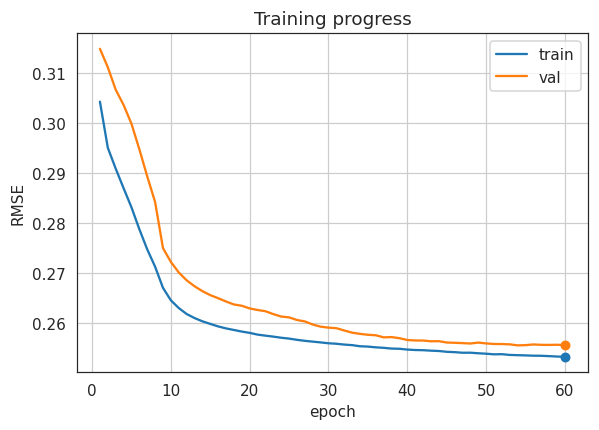

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.3043 MAE=0.2527 R2=-0.0850 | "B": Acc=0.3773 Prec=0.2859 Rec=0.8058 F1=0.4220 AUROC=0.5182
VALID→ "R": RMSE=0.3148 MAE=0.2112 R2=-0.1865 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5469


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2951 MAE=0.2231 R2=-0.0204 | "B": Acc=0.3934 Prec=0.2832 Rec=0.7514 F1=0.4114 AUROC=0.5052
VALID→ "R": RMSE=0.3111 MAE=0.2088 R2=-0.1589 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5710


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2909 MAE=0.2210 R2=0.0082 | "B": Acc=0.3873 Prec=0.2843 Rec=0.7725 F1=0.4157 AUROC=0.5096
VALID→ "R": RMSE=0.3067 MAE=0.2063 R2=-0.1258 | "B": Acc=0.2951 Prec=0.2951 Rec=1.0000 F1=0.4557 AUROC=0.5780


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2870 MAE=0.2190 R2=0.0347 | "B": Acc=0.3930 Prec=0.2857 Rec=0.7674 F1=0.4164 AUROC=0.5135
VALID→ "R": RMSE=0.3036 MAE=0.2042 R2=-0.1035 | "B": Acc=0.2951 Prec=0.2951 Rec=0.9998 F1=0.4557 AUROC=0.5778


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2832 MAE=0.2166 R2=0.0602 | "B": Acc=0.4126 Prec=0.2867 Rec=0.7273 F1=0.4113 AUROC=0.5152
VALID→ "R": RMSE=0.2999 MAE=0.2017 R2=-0.0764 | "B": Acc=0.2948 Prec=0.2946 Rec=0.9969 F1=0.4548 AUROC=0.5702


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2788 MAE=0.2143 R2=0.0890 | "B": Acc=0.4378 Prec=0.2868 Rec=0.6677 F1=0.4013 AUROC=0.5133
VALID→ "R": RMSE=0.2948 MAE=0.1988 R2=-0.0401 | "B": Acc=0.2926 Prec=0.2907 Rec=0.9704 F1=0.4474 AUROC=0.5520


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2748 MAE=0.2134 R2=0.1152 | "B": Acc=0.4625 Prec=0.2858 Rec=0.6041 F1=0.3881 AUROC=0.5091
VALID→ "R": RMSE=0.2894 MAE=0.1959 R2=-0.0022 | "B": Acc=0.2937 Prec=0.2826 Rec=0.9055 F1=0.4308 AUROC=0.5312


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2713 MAE=0.2115 R2=0.1373 | "B": Acc=0.4808 Prec=0.2839 Rec=0.5519 F1=0.3749 AUROC=0.5035
VALID→ "R": RMSE=0.2842 MAE=0.1934 R2=0.0330 | "B": Acc=0.3047 Prec=0.2747 Rec=0.8269 F1=0.4124 AUROC=0.5142


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2671 MAE=0.2059 R2=0.1640 | "B": Acc=0.4853 Prec=0.2813 Rec=0.5303 F1=0.3676 AUROC=0.4992
VALID→ "R": RMSE=0.2750 MAE=0.1904 R2=0.0946 | "B": Acc=0.3313 Prec=0.2689 Rec=0.7366 F1=0.3940 AUROC=0.4996


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2646 MAE=0.2043 R2=0.1795 | "B": Acc=0.4872 Prec=0.2803 Rec=0.5218 F1=0.3647 AUROC=0.4964
VALID→ "R": RMSE=0.2723 MAE=0.1894 R2=0.1127 | "B": Acc=0.3390 Prec=0.2671 Rec=0.7112 F1=0.3884 AUROC=0.4952


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2630 MAE=0.2024 R2=0.1890 | "B": Acc=0.4870 Prec=0.2797 Rec=0.5195 F1=0.3636 AUROC=0.4955
VALID→ "R": RMSE=0.2702 MAE=0.1885 R2=0.1264 | "B": Acc=0.3506 Prec=0.2651 Rec=0.6777 F1=0.3812 AUROC=0.4914


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2619 MAE=0.2013 R2=0.1964 | "B": Acc=0.4864 Prec=0.2789 Rec=0.5175 F1=0.3625 AUROC=0.4939
VALID→ "R": RMSE=0.2686 MAE=0.1878 R2=0.1365 | "B": Acc=0.3471 Prec=0.2658 Rec=0.6877 F1=0.3834 AUROC=0.4940


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2610 MAE=0.2005 R2=0.2013 | "B": Acc=0.4797 Prec=0.2794 Rec=0.5346 F1=0.3670 AUROC=0.4957
VALID→ "R": RMSE=0.2674 MAE=0.1872 R2=0.1441 | "B": Acc=0.3347 Prec=0.2675 Rec=0.7214 F1=0.3902 AUROC=0.5010


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2604 MAE=0.2000 R2=0.2053 | "B": Acc=0.4731 Prec=0.2805 Rec=0.5544 F1=0.3725 AUROC=0.4981
VALID→ "R": RMSE=0.2664 MAE=0.1867 R2=0.1503 | "B": Acc=0.3323 Prec=0.2689 Rec=0.7343 F1=0.3936 AUROC=0.5073


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2599 MAE=0.1996 R2=0.2085 | "B": Acc=0.4724 Prec=0.2820 Rec=0.5628 F1=0.3757 AUROC=0.5008
VALID→ "R": RMSE=0.2656 MAE=0.1863 R2=0.1554 | "B": Acc=0.3393 Prec=0.2689 Rec=0.7205 F1=0.3916 AUROC=0.5084


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2594 MAE=0.1990 R2=0.2115 | "B": Acc=0.4683 Prec=0.2816 Rec=0.5702 F1=0.3770 AUROC=0.5009
VALID→ "R": RMSE=0.2650 MAE=0.1860 R2=0.1593 | "B": Acc=0.3281 Prec=0.2700 Rec=0.7491 F1=0.3969 AUROC=0.5149


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2590 MAE=0.1987 R2=0.2139 | "B": Acc=0.4706 Prec=0.2834 Rec=0.5735 F1=0.3793 AUROC=0.5045
VALID→ "R": RMSE=0.2643 MAE=0.1857 R2=0.1635 | "B": Acc=0.3453 Prec=0.2700 Rec=0.7149 F1=0.3919 AUROC=0.5145


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2587 MAE=0.1985 R2=0.2159 | "B": Acc=0.4678 Prec=0.2827 Rec=0.5764 F1=0.3793 AUROC=0.5036
VALID→ "R": RMSE=0.2638 MAE=0.1855 R2=0.1672 | "B": Acc=0.3311 Prec=0.2705 Rec=0.7464 F1=0.3971 AUROC=0.5193


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2583 MAE=0.1982 R2=0.2178 | "B": Acc=0.4637 Prec=0.2845 Rec=0.5944 F1=0.3848 AUROC=0.5074
VALID→ "R": RMSE=0.2635 MAE=0.1852 R2=0.1689 | "B": Acc=0.3321 Prec=0.2714 Rec=0.7499 F1=0.3986 AUROC=0.5233


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2581 MAE=0.1980 R2=0.2194 | "B": Acc=0.4646 Prec=0.2861 Rec=0.6006 F1=0.3876 AUROC=0.5111
VALID→ "R": RMSE=0.2630 MAE=0.1850 R2=0.1722 | "B": Acc=0.3329 Prec=0.2716 Rec=0.7495 F1=0.3987 AUROC=0.5251


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2577 MAE=0.1977 R2=0.2214 | "B": Acc=0.4641 Prec=0.2860 Rec=0.6012 F1=0.3876 AUROC=0.5111
VALID→ "R": RMSE=0.2627 MAE=0.1849 R2=0.1742 | "B": Acc=0.3307 Prec=0.2718 Rec=0.7549 F1=0.3997 AUROC=0.5267


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2575 MAE=0.1975 R2=0.2227 | "B": Acc=0.4618 Prec=0.2864 Rec=0.6086 F1=0.3895 AUROC=0.5122
VALID→ "R": RMSE=0.2624 MAE=0.1847 R2=0.1758 | "B": Acc=0.3308 Prec=0.2719 Rec=0.7555 F1=0.3999 AUROC=0.5263


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2573 MAE=0.1974 R2=0.2239 | "B": Acc=0.4620 Prec=0.2871 Rec=0.6115 F1=0.3907 AUROC=0.5139
VALID→ "R": RMSE=0.2618 MAE=0.1845 R2=0.1793 | "B": Acc=0.3333 Prec=0.2727 Rec=0.7550 F1=0.4006 AUROC=0.5277


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2571 MAE=0.1973 R2=0.2252 | "B": Acc=0.4604 Prec=0.2884 Rec=0.6217 F1=0.3940 AUROC=0.5168
VALID→ "R": RMSE=0.2613 MAE=0.1844 R2=0.1824 | "B": Acc=0.3293 Prec=0.2737 Rec=0.7697 F1=0.4038 AUROC=0.5327


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2569 MAE=0.1970 R2=0.2263 | "B": Acc=0.4620 Prec=0.2897 Rec=0.6248 F1=0.3959 AUROC=0.5204
VALID→ "R": RMSE=0.2612 MAE=0.1843 R2=0.1834 | "B": Acc=0.3320 Prec=0.2742 Rec=0.7671 F1=0.4040 AUROC=0.5360


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2567 MAE=0.1970 R2=0.2277 | "B": Acc=0.4634 Prec=0.2906 Rec=0.6261 F1=0.3970 AUROC=0.5224
VALID→ "R": RMSE=0.2607 MAE=0.1841 R2=0.1867 | "B": Acc=0.3337 Prec=0.2748 Rec=0.7678 F1=0.4048 AUROC=0.5387


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2565 MAE=0.1968 R2=0.2290 | "B": Acc=0.4616 Prec=0.2907 Rec=0.6308 F1=0.3980 AUROC=0.5228
VALID→ "R": RMSE=0.2604 MAE=0.1840 R2=0.1885 | "B": Acc=0.3265 Prec=0.2753 Rec=0.7858 F1=0.4078 AUROC=0.5414


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2563 MAE=0.1967 R2=0.2299 | "B": Acc=0.4613 Prec=0.2915 Rec=0.6359 F1=0.3997 AUROC=0.5247
VALID→ "R": RMSE=0.2598 MAE=0.1839 R2=0.1923 | "B": Acc=0.3295 Prec=0.2758 Rec=0.7826 F1=0.4079 AUROC=0.5428


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2562 MAE=0.1966 R2=0.2308 | "B": Acc=0.4649 Prec=0.2930 Rec=0.6348 F1=0.4009 AUROC=0.5279
VALID→ "R": RMSE=0.2593 MAE=0.1838 R2=0.1950 | "B": Acc=0.3339 Prec=0.2765 Rec=0.7775 F1=0.4079 AUROC=0.5451


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2560 MAE=0.1964 R2=0.2319 | "B": Acc=0.4671 Prec=0.2935 Rec=0.6315 F1=0.4007 AUROC=0.5287
VALID→ "R": RMSE=0.2591 MAE=0.1837 R2=0.1962 | "B": Acc=0.3366 Prec=0.2771 Rec=0.7756 F1=0.4083 AUROC=0.5461


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2559 MAE=0.1964 R2=0.2324 | "B": Acc=0.4659 Prec=0.2933 Rec=0.6333 F1=0.4009 AUROC=0.5283
VALID→ "R": RMSE=0.2590 MAE=0.1836 R2=0.1969 | "B": Acc=0.3332 Prec=0.2778 Rec=0.7875 F1=0.4107 AUROC=0.5485


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2557 MAE=0.1963 R2=0.2334 | "B": Acc=0.4657 Prec=0.2941 Rec=0.6383 F1=0.4026 AUROC=0.5304
VALID→ "R": RMSE=0.2586 MAE=0.1836 R2=0.1997 | "B": Acc=0.3322 Prec=0.2782 Rec=0.7920 F1=0.4117 AUROC=0.5489


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2556 MAE=0.1963 R2=0.2341 | "B": Acc=0.4644 Prec=0.2942 Rec=0.6419 F1=0.4034 AUROC=0.5311
VALID→ "R": RMSE=0.2581 MAE=0.1835 R2=0.2024 | "B": Acc=0.3312 Prec=0.2786 Rec=0.7969 F1=0.4129 AUROC=0.5501


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2554 MAE=0.1961 R2=0.2354 | "B": Acc=0.4637 Prec=0.2948 Rec=0.6471 F1=0.4051 AUROC=0.5324
VALID→ "R": RMSE=0.2579 MAE=0.1834 R2=0.2039 | "B": Acc=0.3261 Prec=0.2803 Rec=0.8187 F1=0.4176 AUROC=0.5542


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2553 MAE=0.1960 R2=0.2358 | "B": Acc=0.4615 Prec=0.2955 Rec=0.6566 F1=0.4076 AUROC=0.5349
VALID→ "R": RMSE=0.2577 MAE=0.1834 R2=0.2050 | "B": Acc=0.3236 Prec=0.2816 Rec=0.8330 F1=0.4209 AUROC=0.5587


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2552 MAE=0.1959 R2=0.2367 | "B": Acc=0.4593 Prec=0.2955 Rec=0.6622 F1=0.4087 AUROC=0.5349
VALID→ "R": RMSE=0.2576 MAE=0.1833 R2=0.2056 | "B": Acc=0.3182 Prec=0.2837 Rec=0.8591 F1=0.4265 AUROC=0.5626


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2551 MAE=0.1959 R2=0.2373 | "B": Acc=0.4573 Prec=0.2965 Rec=0.6729 F1=0.4116 AUROC=0.5382
VALID→ "R": RMSE=0.2572 MAE=0.1833 R2=0.2082 | "B": Acc=0.3184 Prec=0.2844 Rec=0.8636 F1=0.4279 AUROC=0.5649


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2549 MAE=0.1957 R2=0.2382 | "B": Acc=0.4577 Prec=0.2967 Rec=0.6727 F1=0.4117 AUROC=0.5393
VALID→ "R": RMSE=0.2572 MAE=0.1831 R2=0.2079 | "B": Acc=0.3192 Prec=0.2847 Rec=0.8645 F1=0.4284 AUROC=0.5659


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2549 MAE=0.1957 R2=0.2385 | "B": Acc=0.4574 Prec=0.2973 Rec=0.6769 F1=0.4131 AUROC=0.5401
VALID→ "R": RMSE=0.2570 MAE=0.1831 R2=0.2092 | "B": Acc=0.3162 Prec=0.2861 Rec=0.8807 F1=0.4319 AUROC=0.5690


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2547 MAE=0.1956 R2=0.2394 | "B": Acc=0.4570 Prec=0.2977 Rec=0.6801 F1=0.4141 AUROC=0.5420
VALID→ "R": RMSE=0.2567 MAE=0.1831 R2=0.2115 | "B": Acc=0.3156 Prec=0.2867 Rec=0.8867 F1=0.4334 AUROC=0.5706


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2547 MAE=0.1955 R2=0.2399 | "B": Acc=0.4548 Prec=0.2980 Rec=0.6880 F1=0.4159 AUROC=0.5425
VALID→ "R": RMSE=0.2566 MAE=0.1830 R2=0.2120 | "B": Acc=0.3147 Prec=0.2881 Rec=0.8987 F1=0.4363 AUROC=0.5753


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2546 MAE=0.1954 R2=0.2401 | "B": Acc=0.4585 Prec=0.2991 Rec=0.6841 F1=0.4162 AUROC=0.5441
VALID→ "R": RMSE=0.2565 MAE=0.1829 R2=0.2121 | "B": Acc=0.3156 Prec=0.2883 Rec=0.8985 F1=0.4366 AUROC=0.5778


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2545 MAE=0.1954 R2=0.2407 | "B": Acc=0.4587 Prec=0.2993 Rec=0.6849 F1=0.4166 AUROC=0.5454
VALID→ "R": RMSE=0.2564 MAE=0.1829 R2=0.2130 | "B": Acc=0.3165 Prec=0.2888 Rec=0.9001 F1=0.4373 AUROC=0.5801


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2545 MAE=0.1954 R2=0.2411 | "B": Acc=0.4559 Prec=0.2989 Rec=0.6904 F1=0.4172 AUROC=0.5447
VALID→ "R": RMSE=0.2564 MAE=0.1828 R2=0.2129 | "B": Acc=0.3122 Prec=0.2902 Rec=0.9202 F1=0.4413 AUROC=0.5828


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2543 MAE=0.1953 R2=0.2421 | "B": Acc=0.4542 Prec=0.2992 Rec=0.6964 F1=0.4186 AUROC=0.5461
VALID→ "R": RMSE=0.2562 MAE=0.1828 R2=0.2145 | "B": Acc=0.3120 Prec=0.2907 Rec=0.9248 F1=0.4424 AUROC=0.5847


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2542 MAE=0.1952 R2=0.2425 | "B": Acc=0.4548 Prec=0.3001 Rec=0.6997 F1=0.4200 AUROC=0.5483
VALID→ "R": RMSE=0.2561 MAE=0.1827 R2=0.2149 | "B": Acc=0.3119 Prec=0.2913 Rec=0.9295 F1=0.4436 AUROC=0.5880


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2541 MAE=0.1951 R2=0.2432 | "B": Acc=0.4535 Prec=0.2998 Rec=0.7017 F1=0.4201 AUROC=0.5483
VALID→ "R": RMSE=0.2560 MAE=0.1826 R2=0.2153 | "B": Acc=0.3120 Prec=0.2915 Rec=0.9308 F1=0.4440 AUROC=0.5885


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2541 MAE=0.1951 R2=0.2431 | "B": Acc=0.4533 Prec=0.2998 Rec=0.7022 F1=0.4202 AUROC=0.5489
VALID→ "R": RMSE=0.2560 MAE=0.1826 R2=0.2158 | "B": Acc=0.3119 Prec=0.2919 Rec=0.9338 F1=0.4447 AUROC=0.5900


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2540 MAE=0.1948 R2=0.2438 | "B": Acc=0.4532 Prec=0.3006 Rec=0.7071 F1=0.4218 AUROC=0.5502
VALID→ "R": RMSE=0.2561 MAE=0.1825 R2=0.2146 | "B": Acc=0.3122 Prec=0.2924 Rec=0.9372 F1=0.4458 AUROC=0.5930


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ "R": RMSE=0.2539 MAE=0.1949 R2=0.2443 | "B": Acc=0.4525 Prec=0.3007 Rec=0.7093 F1=0.4223 AUROC=0.5511
VALID→ "R": RMSE=0.2560 MAE=0.1825 R2=0.2157 | "B": Acc=0.3112 Prec=0.2927 Rec=0.9415 F1=0.4465 AUROC=0.5941


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ "R": RMSE=0.2538 MAE=0.1947 R2=0.2450 | "B": Acc=0.4524 Prec=0.3010 Rec=0.7116 F1=0.4231 AUROC=0.5517
VALID→ "R": RMSE=0.2559 MAE=0.1824 R2=0.2163 | "B": Acc=0.3109 Prec=0.2930 Rec=0.9449 F1=0.4473 AUROC=0.5956


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ "R": RMSE=0.2538 MAE=0.1947 R2=0.2449 | "B": Acc=0.4509 Prec=0.3014 Rec=0.7179 F1=0.4245 AUROC=0.5534
VALID→ "R": RMSE=0.2558 MAE=0.1824 R2=0.2164 | "B": Acc=0.3122 Prec=0.2932 Rec=0.9435 F1=0.4474 AUROC=0.5970


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ "R": RMSE=0.2537 MAE=0.1946 R2=0.2458 | "B": Acc=0.4533 Prec=0.3017 Rec=0.7134 F1=0.4241 AUROC=0.5543
VALID→ "R": RMSE=0.2558 MAE=0.1823 R2=0.2168 | "B": Acc=0.3134 Prec=0.2938 Rec=0.9448 F1=0.4482 AUROC=0.6001


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ "R": RMSE=0.2536 MAE=0.1946 R2=0.2461 | "B": Acc=0.4544 Prec=0.3023 Rec=0.7142 F1=0.4248 AUROC=0.5549
VALID→ "R": RMSE=0.2556 MAE=0.1823 R2=0.2180 | "B": Acc=0.3155 Prec=0.2943 Rec=0.9437 F1=0.4487 AUROC=0.6022


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ "R": RMSE=0.2536 MAE=0.1946 R2=0.2463 | "B": Acc=0.4577 Prec=0.3034 Rec=0.7115 F1=0.4254 AUROC=0.5568
VALID→ "R": RMSE=0.2556 MAE=0.1823 R2=0.2178 | "B": Acc=0.3198 Prec=0.2949 Rec=0.9385 F1=0.4488 AUROC=0.6044


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ "R": RMSE=0.2535 MAE=0.1944 R2=0.2467 | "B": Acc=0.4602 Prec=0.3038 Rec=0.7071 F1=0.4250 AUROC=0.5572
VALID→ "R": RMSE=0.2558 MAE=0.1822 R2=0.2169 | "B": Acc=0.3204 Prec=0.2956 Rec=0.9418 F1=0.4499 AUROC=0.6080


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ "R": RMSE=0.2535 MAE=0.1944 R2=0.2468 | "B": Acc=0.4578 Prec=0.3039 Rec=0.7141 F1=0.4263 AUROC=0.5581
VALID→ "R": RMSE=0.2557 MAE=0.1822 R2=0.2174 | "B": Acc=0.3167 Prec=0.2955 Rec=0.9503 F1=0.4508 AUROC=0.6101


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ "R": RMSE=0.2534 MAE=0.1944 R2=0.2472 | "B": Acc=0.4573 Prec=0.3042 Rec=0.7176 F1=0.4273 AUROC=0.5595
VALID→ "R": RMSE=0.2557 MAE=0.1821 R2=0.2175 | "B": Acc=0.3203 Prec=0.2966 Rec=0.9499 F1=0.4520 AUROC=0.6140


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ "R": RMSE=0.2534 MAE=0.1942 R2=0.2477 | "B": Acc=0.4572 Prec=0.3049 Rec=0.7218 F1=0.4287 AUROC=0.5614
VALID→ "R": RMSE=0.2557 MAE=0.1820 R2=0.2173 | "B": Acc=0.3168 Prec=0.2962 Rec=0.9560 F1=0.4523 AUROC=0.6154


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ "R": RMSE=0.2533 MAE=0.1942 R2=0.2480 | "B": Acc=0.4547 Prec=0.3046 Rec=0.7269 F1=0.4293 AUROC=0.5610
VALID→ "R": RMSE=0.2556 MAE=0.1820 R2=0.2178 | "B": Acc=0.3164 Prec=0.2962 Rec=0.9569 F1=0.4524 AUROC=0.6157
Early stopping at epoch 60
✅ Final best model (_fin) saved: AAPL_0.25559_fin.pth
Delete variables to free memory...


[I 2025-09-21 23:44:29,032] Trial 5 finished with value: 0.255587637424469 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.2867671011593284, 'DROPOUT_LONG': 0.2559076358812501, 'ATT_DROPOUT': 0.22903361977730718, 'INITIAL_LR': 2.9515799337833365e-05, 'ETA_MIN': 8.308453340389573e-06, 'WEIGHT_DECAY': 0.00023245926383998162, 'CLIPNORM': 1.6752054003785983}. Best is trial 1 with value: 0.23971986770629883.



▶ Trial 6 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.17527207782715615, 'DROPOUT_LONG': 0.10840853559670191, 'ATT_DROPOUT': 0.1837001602158621, 'INITIAL_LR': 0.0006488846559186966, 'ETA_MIN': 7.818623884438339e-06, 'WEIGHT_DECAY': 1.720808428954186e-05, 'CLIPNORM': 7.418791053144164}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


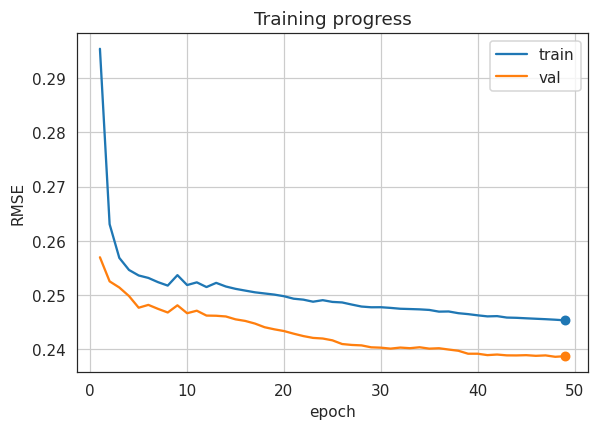

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2954 MAE=0.2313 R2=-0.0385 | "B": Acc=0.2762 Prec=0.2722 Rec=0.9884 F1=0.4268 AUROC=0.4257
VALID→ "R": RMSE=0.2570 MAE=0.2053 R2=0.1873 | "B": Acc=0.2804 Prec=0.2804 Rec=1.0000 F1=0.4380 AUROC=0.2777


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2630 MAE=0.2027 R2=0.1763 | "B": Acc=0.2698 Prec=0.2691 Rec=0.9779 F1=0.4221 AUROC=0.3412
VALID→ "R": RMSE=0.2525 MAE=0.1844 R2=0.2152 | "B": Acc=0.2779 Prec=0.2785 Rec=0.9905 F1=0.4348 AUROC=0.2600


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2568 MAE=0.1951 R2=0.2147 | "B": Acc=0.2640 Prec=0.2623 Rec=0.9377 F1=0.4099 AUROC=0.3226
VALID→ "R": RMSE=0.2514 MAE=0.1820 R2=0.2222 | "B": Acc=0.2699 Prec=0.2720 Rec=0.9564 F1=0.4235 AUROC=0.2537


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2546 MAE=0.1942 R2=0.2283 | "B": Acc=0.2582 Prec=0.2533 Rec=0.8831 F1=0.3936 AUROC=0.3114
VALID→ "R": RMSE=0.2498 MAE=0.1810 R2=0.2319 | "B": Acc=0.2644 Prec=0.2670 Rec=0.9299 F1=0.4148 AUROC=0.2525


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2536 MAE=0.1928 R2=0.2344 | "B": Acc=0.2589 Prec=0.2530 Rec=0.8797 F1=0.3929 AUROC=0.3119
VALID→ "R": RMSE=0.2477 MAE=0.1830 R2=0.2451 | "B": Acc=0.2633 Prec=0.2660 Rec=0.9245 F1=0.4131 AUROC=0.2533


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2532 MAE=0.1935 R2=0.2371 | "B": Acc=0.2593 Prec=0.2535 Rec=0.8827 F1=0.3939 AUROC=0.3154
VALID→ "R": RMSE=0.2482 MAE=0.1808 R2=0.2419 | "B": Acc=0.2644 Prec=0.2671 Rec=0.9309 F1=0.4151 AUROC=0.2516


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2524 MAE=0.1923 R2=0.2419 | "B": Acc=0.2574 Prec=0.2521 Rec=0.8762 F1=0.3915 AUROC=0.3101
VALID→ "R": RMSE=0.2475 MAE=0.1808 R2=0.2464 | "B": Acc=0.2628 Prec=0.2654 Rec=0.9213 F1=0.4121 AUROC=0.2531


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2517 MAE=0.1915 R2=0.2456 | "B": Acc=0.2556 Prec=0.2493 Rec=0.8605 F1=0.3866 AUROC=0.3088
VALID→ "R": RMSE=0.2468 MAE=0.1811 R2=0.2504 | "B": Acc=0.2605 Prec=0.2629 Rec=0.9080 F1=0.4078 AUROC=0.2525


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2537 MAE=0.1937 R2=0.2341 | "B": Acc=0.2568 Prec=0.2512 Rec=0.8715 F1=0.3900 AUROC=0.3137
VALID→ "R": RMSE=0.2481 MAE=0.1886 R2=0.2424 | "B": Acc=0.2540 Prec=0.2560 Rec=0.8710 F1=0.3957 AUROC=0.2540


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2518 MAE=0.1922 R2=0.2450 | "B": Acc=0.2546 Prec=0.2498 Rec=0.8658 F1=0.3878 AUROC=0.3004
VALID→ "R": RMSE=0.2466 MAE=0.1807 R2=0.2512 | "B": Acc=0.2594 Prec=0.2621 Rec=0.9039 F1=0.4063 AUROC=0.2498


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2523 MAE=0.1926 R2=0.2421 | "B": Acc=0.2552 Prec=0.2498 Rec=0.8641 F1=0.3875 AUROC=0.3110
VALID→ "R": RMSE=0.2471 MAE=0.1911 R2=0.2484 | "B": Acc=0.2514 Prec=0.2529 Rec=0.8540 F1=0.3902 AUROC=0.2530


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2515 MAE=0.1920 R2=0.2473 | "B": Acc=0.2544 Prec=0.2492 Rec=0.8621 F1=0.3867 AUROC=0.3014
VALID→ "R": RMSE=0.2462 MAE=0.1813 R2=0.2539 | "B": Acc=0.2589 Prec=0.2615 Rec=0.9009 F1=0.4054 AUROC=0.2507


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2522 MAE=0.1917 R2=0.2426 | "B": Acc=0.2551 Prec=0.2493 Rec=0.8612 F1=0.3867 AUROC=0.3079
VALID→ "R": RMSE=0.2462 MAE=0.1908 R2=0.2541 | "B": Acc=0.2513 Prec=0.2519 Rec=0.8474 F1=0.3883 AUROC=0.2559


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2516 MAE=0.1924 R2=0.2467 | "B": Acc=0.2553 Prec=0.2489 Rec=0.8583 F1=0.3859 AUROC=0.3057
VALID→ "R": RMSE=0.2461 MAE=0.1908 R2=0.2549 | "B": Acc=0.2583 Prec=0.2596 Rec=0.8883 F1=0.4018 AUROC=0.2596


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ "R": RMSE=0.2511 MAE=0.1916 R2=0.2492 | "B": Acc=0.2566 Prec=0.2507 Rec=0.8680 F1=0.3890 AUROC=0.3091
VALID→ "R": RMSE=0.2455 MAE=0.1897 R2=0.2581 | "B": Acc=0.2593 Prec=0.2604 Rec=0.8917 F1=0.4030 AUROC=0.2693


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ "R": RMSE=0.2508 MAE=0.1910 R2=0.2512 | "B": Acc=0.2560 Prec=0.2497 Rec=0.8625 F1=0.3873 AUROC=0.3080
VALID→ "R": RMSE=0.2452 MAE=0.1892 R2=0.2598 | "B": Acc=0.2614 Prec=0.2607 Rec=0.8898 F1=0.4032 AUROC=0.2787


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ "R": RMSE=0.2505 MAE=0.1906 R2=0.2530 | "B": Acc=0.2581 Prec=0.2501 Rec=0.8613 F1=0.3876 AUROC=0.3131
VALID→ "R": RMSE=0.2447 MAE=0.1889 R2=0.2628 | "B": Acc=0.2645 Prec=0.2620 Rec=0.8935 F1=0.4052 AUROC=0.2921


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ "R": RMSE=0.2503 MAE=0.1906 R2=0.2543 | "B": Acc=0.2597 Prec=0.2519 Rec=0.8708 F1=0.3908 AUROC=0.3173
VALID→ "R": RMSE=0.2441 MAE=0.1888 R2=0.2668 | "B": Acc=0.2715 Prec=0.2702 Rec=0.9392 F1=0.4197 AUROC=0.3022


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ "R": RMSE=0.2501 MAE=0.1907 R2=0.2556 | "B": Acc=0.2602 Prec=0.2537 Rec=0.8826 F1=0.3941 AUROC=0.3168
VALID→ "R": RMSE=0.2437 MAE=0.1883 R2=0.2691 | "B": Acc=0.2696 Prec=0.2678 Rec=0.9254 F1=0.4154 AUROC=0.2969


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ "R": RMSE=0.2498 MAE=0.1904 R2=0.2573 | "B": Acc=0.2591 Prec=0.2532 Rec=0.8806 F1=0.3933 AUROC=0.3129
VALID→ "R": RMSE=0.2434 MAE=0.1878 R2=0.2711 | "B": Acc=0.2728 Prec=0.2696 Rec=0.9324 F1=0.4183 AUROC=0.3010


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ "R": RMSE=0.2493 MAE=0.1899 R2=0.2601 | "B": Acc=0.2602 Prec=0.2537 Rec=0.8827 F1=0.3942 AUROC=0.3126
VALID→ "R": RMSE=0.2429 MAE=0.1873 R2=0.2740 | "B": Acc=0.2688 Prec=0.2679 Rec=0.9275 F1=0.4157 AUROC=0.2831


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ "R": RMSE=0.2491 MAE=0.1899 R2=0.2611 | "B": Acc=0.2595 Prec=0.2554 Rec=0.8957 F1=0.3974 AUROC=0.3085
VALID→ "R": RMSE=0.2424 MAE=0.1869 R2=0.2766 | "B": Acc=0.2727 Prec=0.2701 Rec=0.9364 F1=0.4193 AUROC=0.2826
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24244_chp.pth


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ "R": RMSE=0.2488 MAE=0.1895 R2=0.2633 | "B": Acc=0.2591 Prec=0.2542 Rec=0.8884 F1=0.3953 AUROC=0.3048
VALID→ "R": RMSE=0.2421 MAE=0.1860 R2=0.2786 | "B": Acc=0.2665 Prec=0.2654 Rec=0.9136 F1=0.4113 AUROC=0.2720
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24210_chp.pth


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ "R": RMSE=0.2491 MAE=0.1899 R2=0.2617 | "B": Acc=0.2580 Prec=0.2545 Rec=0.8925 F1=0.3961 AUROC=0.3032
VALID→ "R": RMSE=0.2420 MAE=0.1852 R2=0.2793 | "B": Acc=0.2649 Prec=0.2610 Rec=0.8855 F1=0.4032 AUROC=0.2746
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24199_chp.pth


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ "R": RMSE=0.2487 MAE=0.1896 R2=0.2636 | "B": Acc=0.2589 Prec=0.2532 Rec=0.8813 F1=0.3933 AUROC=0.3084
VALID→ "R": RMSE=0.2417 MAE=0.1855 R2=0.2813 | "B": Acc=0.2672 Prec=0.2655 Rec=0.9134 F1=0.4114 AUROC=0.2729
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24165_chp.pth


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ "R": RMSE=0.2486 MAE=0.1898 R2=0.2641 | "B": Acc=0.2586 Prec=0.2536 Rec=0.8850 F1=0.3943 AUROC=0.3083
VALID→ "R": RMSE=0.2410 MAE=0.1836 R2=0.2853 | "B": Acc=0.2688 Prec=0.2671 Rec=0.9216 F1=0.4141 AUROC=0.2699
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24097_chp.pth


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ "R": RMSE=0.2482 MAE=0.1893 R2=0.2665 | "B": Acc=0.2603 Prec=0.2541 Rec=0.8850 F1=0.3948 AUROC=0.3127
VALID→ "R": RMSE=0.2408 MAE=0.1838 R2=0.2863 | "B": Acc=0.2709 Prec=0.2687 Rec=0.9296 F1=0.4169 AUROC=0.2779
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24080_chp.pth


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ "R": RMSE=0.2479 MAE=0.1889 R2=0.2686 | "B": Acc=0.2615 Prec=0.2542 Rec=0.8834 F1=0.3948 AUROC=0.3190
VALID→ "R": RMSE=0.2407 MAE=0.1833 R2=0.2868 | "B": Acc=0.2720 Prec=0.2682 Rec=0.9233 F1=0.4157 AUROC=0.2850
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24072_chp.pth


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ "R": RMSE=0.2477 MAE=0.1888 R2=0.2694 | "B": Acc=0.2630 Prec=0.2541 Rec=0.8801 F1=0.3944 AUROC=0.3233
VALID→ "R": RMSE=0.2404 MAE=0.1822 R2=0.2889 | "B": Acc=0.2683 Prec=0.2656 Rec=0.9114 F1=0.4113 AUROC=0.2718
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24037_chp.pth


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ "R": RMSE=0.2478 MAE=0.1888 R2=0.2693 | "B": Acc=0.2629 Prec=0.2534 Rec=0.8756 F1=0.3931 AUROC=0.3236
VALID→ "R": RMSE=0.2403 MAE=0.1806 R2=0.2893 | "B": Acc=0.2708 Prec=0.2687 Rec=0.9293 F1=0.4168 AUROC=0.2708
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24030_chp.pth


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ "R": RMSE=0.2476 MAE=0.1888 R2=0.2701 | "B": Acc=0.2628 Prec=0.2558 Rec=0.8925 F1=0.3976 AUROC=0.3249
VALID→ "R": RMSE=0.2401 MAE=0.1800 R2=0.2903 | "B": Acc=0.2718 Prec=0.2693 Rec=0.9319 F1=0.4178 AUROC=0.2752
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24012_chp.pth


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ "R": RMSE=0.2475 MAE=0.1887 R2=0.2710 | "B": Acc=0.2631 Prec=0.2564 Rec=0.8965 F1=0.3988 AUROC=0.3246
VALID→ "R": RMSE=0.2403 MAE=0.1788 R2=0.2892 | "B": Acc=0.2706 Prec=0.2680 Rec=0.9249 F1=0.4156 AUROC=0.2742


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ "R": RMSE=0.2474 MAE=0.1887 R2=0.2713 | "B": Acc=0.2633 Prec=0.2561 Rec=0.8937 F1=0.3981 AUROC=0.3273
VALID→ "R": RMSE=0.2402 MAE=0.1782 R2=0.2899 | "B": Acc=0.2727 Prec=0.2706 Rec=0.9402 F1=0.4203 AUROC=0.2768


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ "R": RMSE=0.2474 MAE=0.1885 R2=0.2717 | "B": Acc=0.2643 Prec=0.2567 Rec=0.8961 F1=0.3991 AUROC=0.3310
VALID→ "R": RMSE=0.2404 MAE=0.1787 R2=0.2888 | "B": Acc=0.2697 Prec=0.2682 Rec=0.9279 F1=0.4161 AUROC=0.2746


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ "R": RMSE=0.2473 MAE=0.1883 R2=0.2723 | "B": Acc=0.2644 Prec=0.2577 Rec=0.9030 F1=0.4010 AUROC=0.3321
VALID→ "R": RMSE=0.2401 MAE=0.1789 R2=0.2903 | "B": Acc=0.2724 Prec=0.2710 Rec=0.9435 F1=0.4210 AUROC=0.2780


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ "R": RMSE=0.2469 MAE=0.1881 R2=0.2741 | "B": Acc=0.2646 Prec=0.2580 Rec=0.9048 F1=0.4015 AUROC=0.3309
VALID→ "R": RMSE=0.2402 MAE=0.1789 R2=0.2899 | "B": Acc=0.2704 Prec=0.2693 Rec=0.9352 F1=0.4182 AUROC=0.2761


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ "R": RMSE=0.2470 MAE=0.1879 R2=0.2740 | "B": Acc=0.2647 Prec=0.2579 Rec=0.9041 F1=0.4014 AUROC=0.3324
VALID→ "R": RMSE=0.2400 MAE=0.1787 R2=0.2913 | "B": Acc=0.2691 Prec=0.2685 Rec=0.9313 F1=0.4168 AUROC=0.2789
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23996_chp.pth


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ "R": RMSE=0.2467 MAE=0.1875 R2=0.2758 | "B": Acc=0.2641 Prec=0.2576 Rec=0.9027 F1=0.4008 AUROC=0.3330
VALID→ "R": RMSE=0.2397 MAE=0.1797 R2=0.2927 | "B": Acc=0.2698 Prec=0.2684 Rec=0.9293 F1=0.4165 AUROC=0.2824
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23973_chp.pth


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ "R": RMSE=0.2465 MAE=0.1874 R2=0.2768 | "B": Acc=0.2643 Prec=0.2572 Rec=0.8997 F1=0.4001 AUROC=0.3294
VALID→ "R": RMSE=0.2392 MAE=0.1796 R2=0.2959 | "B": Acc=0.2680 Prec=0.2669 Rec=0.9216 F1=0.4139 AUROC=0.2794
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23919_chp.pth


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ "R": RMSE=0.2463 MAE=0.1871 R2=0.2781 | "B": Acc=0.2628 Prec=0.2561 Rec=0.8942 F1=0.3981 AUROC=0.3281
VALID→ "R": RMSE=0.2392 MAE=0.1797 R2=0.2959 | "B": Acc=0.2675 Prec=0.2651 Rec=0.9097 F1=0.4106 AUROC=0.2818
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23918_chp.pth


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ "R": RMSE=0.2461 MAE=0.1870 R2=0.2793 | "B": Acc=0.2628 Prec=0.2556 Rec=0.8910 F1=0.3972 AUROC=0.3240
VALID→ "R": RMSE=0.2389 MAE=0.1794 R2=0.2974 | "B": Acc=0.2675 Prec=0.2656 Rec=0.9131 F1=0.4115 AUROC=0.2805
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23893_chp.pth


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ "R": RMSE=0.2461 MAE=0.1869 R2=0.2790 | "B": Acc=0.2627 Prec=0.2558 Rec=0.8927 F1=0.3977 AUROC=0.3293
VALID→ "R": RMSE=0.2390 MAE=0.1781 R2=0.2967 | "B": Acc=0.2681 Prec=0.2665 Rec=0.9188 F1=0.4131 AUROC=0.2838


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ "R": RMSE=0.2458 MAE=0.1866 R2=0.2805 | "B": Acc=0.2623 Prec=0.2554 Rec=0.8905 F1=0.3970 AUROC=0.3253
VALID→ "R": RMSE=0.2389 MAE=0.1786 R2=0.2977 | "B": Acc=0.2684 Prec=0.2666 Rec=0.9190 F1=0.4133 AUROC=0.2849
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23888_chp.pth


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ "R": RMSE=0.2458 MAE=0.1865 R2=0.2808 | "B": Acc=0.2624 Prec=0.2554 Rec=0.8902 F1=0.3969 AUROC=0.3269
VALID→ "R": RMSE=0.2389 MAE=0.1782 R2=0.2977 | "B": Acc=0.2690 Prec=0.2673 Rec=0.9226 F1=0.4145 AUROC=0.2859
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23887_chp.pth


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ "R": RMSE=0.2457 MAE=0.1864 R2=0.2813 | "B": Acc=0.2626 Prec=0.2553 Rec=0.8892 F1=0.3967 AUROC=0.3257
VALID→ "R": RMSE=0.2389 MAE=0.1779 R2=0.2974 | "B": Acc=0.2684 Prec=0.2668 Rec=0.9204 F1=0.4137 AUROC=0.2832


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ "R": RMSE=0.2456 MAE=0.1862 R2=0.2818 | "B": Acc=0.2619 Prec=0.2547 Rec=0.8865 F1=0.3958 AUROC=0.3221
VALID→ "R": RMSE=0.2388 MAE=0.1781 R2=0.2981 | "B": Acc=0.2679 Prec=0.2661 Rec=0.9165 F1=0.4125 AUROC=0.2828
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23880_chp.pth


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ "R": RMSE=0.2455 MAE=0.1862 R2=0.2823 | "B": Acc=0.2616 Prec=0.2542 Rec=0.8832 F1=0.3947 AUROC=0.3217
VALID→ "R": RMSE=0.2389 MAE=0.1776 R2=0.2977 | "B": Acc=0.2674 Prec=0.2657 Rec=0.9142 F1=0.4117 AUROC=0.2832


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ "R": RMSE=0.2455 MAE=0.1860 R2=0.2829 | "B": Acc=0.2612 Prec=0.2545 Rec=0.8866 F1=0.3955 AUROC=0.3197
VALID→ "R": RMSE=0.2386 MAE=0.1780 R2=0.2992 | "B": Acc=0.2670 Prec=0.2650 Rec=0.9099 F1=0.4105 AUROC=0.2819
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.23862_chp.pth


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ "R": RMSE=0.2453 MAE=0.1860 R2=0.2835 | "B": Acc=0.2611 Prec=0.2544 Rec=0.8858 F1=0.3953 AUROC=0.3207
VALID→ "R": RMSE=0.2387 MAE=0.1776 R2=0.2985 | "B": Acc=0.2669 Prec=0.2650 Rec=0.9105 F1=0.4106 AUROC=0.2827


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
